#  Compare biclusters detected in two independent datasets


In [1]:
import sys,os
import numpy as np
import pandas as pd

from utils.method import read_bic_table

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
subt_anno_tcga = pd.read_csv("data/preprocessed_v6/TCGA-BRCA_1079_17Kgenes.Xena_TCGA_PanCan.subtypes_and_signatures_v6.tsv",sep ="\t",index_col=0)
anno_tcga = pd.read_csv("data/preprocessed_v6/TCGA-BRCA_1079.Xena_TCGA_PanCan.annotation_v6.tsv",sep ="\t",index_col=0)
anno_tcga = pd.concat([anno_tcga.loc[subt_anno_tcga.index,:], subt_anno_tcga],axis=1)
anno_tcga["stage_34"] = anno_tcga["stage_3"] + anno_tcga["stage_4"] 

subt_anno_meta = pd.read_csv("data/preprocessed_v6/METABRIC_1904_17Kgenes.subtypes_and_signatures_v6.tsv",sep ="\t",index_col=0)
anno_meta = pd.read_csv("data/preprocessed_v6/METABRIC_1904.annotation_v6.tsv",sep ="\t",index_col=0)
anno_meta = pd.concat([anno_meta.loc[subt_anno_meta.index,:], subt_anno_meta],axis=1)
anno_meta["stage_34"] = anno_meta["stage_3"] + anno_meta["stage_4"]

In [3]:
exprs_tcga = pd.read_csv("data/preprocessed_v6/TCGA-BRCA_1079_17Kgenes.Xena_TCGA_PanCan.log2_exprs_z_v6.tsv",sep = "\t",index_col=0)
exprs_meta = pd.read_csv("data/preprocessed_v6/METABRIC_1904_17Kgenes.log2_exprs_z_v6.tsv",sep = "\t",index_col=0)

In [4]:
#suffix = ".consensus_kmeans_v2_samples.42.bin=kmeans,pval=0.01,clust=WGCNA,ds=0,dch=0.995.tsv"
cseed = 42
suffix = ".consensus_seed="+str(cseed)+".bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv"

bics_tcga = read_bic_table("results_on_real_data_tuned_v2/TCGA_optimized/TCGA-BRCA"+suffix)
print("Biclusters in Discovery dataset:", bics_tcga.shape[0])
bics_tcga = bics_tcga.loc[bics_tcga["detected_n_times"]>1,:]
print("\t:", bics_tcga.shape[0])

bics_meta = read_bic_table("results_on_real_data_tuned_v2/METABRIC_optimized/METABRIC"+suffix)
print("Biclusters in Validation dataset:", bics_meta.shape[0])
bics_meta = bics_meta.loc[bics_meta["detected_n_times"]>1,:]
print("\t:", bics_meta.shape[0])

Biclusters in Discovery dataset: 209
	: 209
Biclusters in Validation dataset: 180
	: 180


In [11]:
"results_on_real_data_tuned_v2/TCGA_optimized/TCGA-BRCA"+suffix

'results_on_real_data_tuned_v2/TCGA_optimized/TCGA-BRCA.consensus_seed=42.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv'

### similarity to PAM50 subtypes

In [12]:
from utils.eval import  evaluate_overlaps_ARI, apply_bh

In [13]:
all_samples_meta = set(exprs_meta.columns.values)
subts_meta = {}
subts_meta["Luminal"] = set([])
for subt in set(anno_meta["PAM50"].values):
    #if not subt.startswith("Lum"):
    subts_meta[subt] = set(anno_meta.loc[anno_meta["PAM50"]==subt,:].index.values)
    print(subt, len(subts_meta[subt]))
    if subt.startswith("Lum"):
        subts_meta["Luminal"] |= set(anno_meta.loc[anno_meta["PAM50"]==subt,:].index.values)
    


pvals_meta, is_enriched_meta, ari_meta = evaluate_overlaps_ARI(bics_meta, subts_meta, all_samples_meta)
adj_pvals_meta  = apply_bh(pvals_meta, a = 0.05)
adj_pvals_meta["min_pval_META"] = adj_pvals_meta.min(axis=1)
ari_meta["max_ARI_META"] = ari_meta.max(axis=1)
#pvals_meta.sort_values(by='LumA')#.loc[adj_pvals['min_pval']>0.01,:]

Normal 54
LumA 598
Her2 244
Basal 244
LumB 764


In [14]:
#potentially_novel.loc[:,["bm_id",'n_shared_genes']]

In [9]:
pvals_meta.loc[pvals_meta["LumA"]>0.01,:].sort_values(by='LumB')

,Normal,Her2,Basal,LumA,LumB,Luminal
8,4.182916e-02,2.674539e-07,0.266123,0.015884,0.000001,4.649751e-07
63,2.575852e-01,3.319199e-01,0.003394,0.016369,0.000002,4.506058e-04
1,3.624859e-01,1.719605e-04,0.000002,0.742278,0.000002,2.096358e-06
73,4.341467e-07,2.059067e-06,0.000002,0.036337,0.000003,2.929354e-06
58,5.593979e-02,1.784842e-06,0.000002,0.051575,0.000003,2.148728e-06
27,1.952768e-03,2.461274e-06,0.000002,0.587849,0.000003,2.088950e-06
46,3.124443e-03,1.078222e-06,0.000001,0.423842,0.000003,2.207781e-06
52,7.534179e-07,1.623591e-02,0.000003,0.094793,0.000003,3.451166e-06
166,2.016191e-04,1.676166e-04,0.000002,0.032363,0.000003,3.392825e-06
84,4.118725e-06,2.279140e-06,0.000002,0.215586,0.000003,3.392825e-06


In [15]:
all_samples_tcga = set(exprs_tcga.columns.values)

subts_tcga = {}
subts_tcga["Luminal"] = set([])
for subt in set(anno_tcga["PAM50"].values):
    #if not subt.startswith("Lum"):
    subts_tcga[subt] = set(anno_tcga.loc[anno_tcga["PAM50"]==subt,:].index.values)
    print(subt, len(subts_tcga[subt]))
    if subt.startswith("Lum"):
        subts_tcga["Luminal"] |= set(anno_tcga.loc[anno_tcga["PAM50"]==subt,:].index.values)
    


pvals_tcga, is_enriched, ari_tcga = evaluate_overlaps_ARI(bics_tcga, subts_tcga, all_samples_tcga)
adj_pvals_tcga  = apply_bh(pvals_tcga, a = 0.05)
adj_pvals_tcga["min_pval_TCGA"] = adj_pvals_tcga.min(axis=1)
ari_tcga["max_ARI_TCGA"] = ari_tcga.max(axis=1)
#adj_pvals.sort_values(by='LumA')#.loc[adj_pvals['min_pval']>0.01,:]

Normal 32
LumA 426
Her2 108
Basal 195
LumB 318


In [16]:
#ari_tcga.loc[28,:]

In [17]:
#d_os = add_survival(d, anno_tcga, event= "OS", surv_time ="OS.time",covariates = covariates)
#d_os.sort_values(by="OS.LogR_p_value_BH")

In [18]:
bics_tcga["max_ARI"] = ari_tcga.loc[bics_tcga.index,"max_ARI_TCGA"]
bics_meta["max_ARI"] = ari_meta.loc[bics_meta.index,"max_ARI_META"]

In [19]:
#sorted(pvals["LumA"].values)

# Best matches

* significant
* J>=0.1

most interesting - with low max. ARI in TCGA and METABRIC 

In [20]:
from utils.eval import find_best_matching_biclusters

In [21]:
b1 = bics_tcga#.loc[bics_d["SNR"]>1.5,:]
b2 = bics_meta#.loc[bics_v["SNR"]>1.5,:]
print(b1.shape[0],b2.shape[0])
bm = find_best_matching_biclusters(b1,b2,(exprs_tcga.shape[0],0), by="genes")

bics_tcga["bm_id"] = bm.loc[bics_tcga.index,"bm_id"]
bics_tcga["bm_J"] = bm.loc[bics_tcga.index,"J"]

209 180


In [22]:
bm2 = find_best_matching_biclusters(b2,b1,(exprs_meta.shape[0],0), by="genes")
bics_meta["bm_id"] = bm2.loc[bics_meta.index,"bm_id"]
bics_meta["bm_J"] = bm2.loc[bics_meta.index,"J"]

bm = bm.dropna()
#bm = bm.sort_values("adj_pval")
print("matched:",bm.shape[0])
bm = bm.loc[bm["J"]>=0.1,:].sort_values("n_shared_genes",ascending =False)
print("matched with J>0.1:",bm.shape[0])
bm

matched: 75
matched with J>0.1: 45


,bm_id,J,adj_pval,genes,n_genes,n_samples,samples,shared_genes,n_shared_genes,bm_genes,bm_n_genes,bm_n_samples,bm_samples,shared_samples,n_shared_samples
1,2,0.149644,0.0,"{TTC6, NR2E1, VSTM5, CCKBR, SHC4, TMPRSS12, ZG...",331,195,"{TCGA-AR-A1AR-01, TCGA-AO-A0JL-01, TCGA-S3-AA1...","{RASAL1, CCKBR, SHC4, HRK, RPRM, MAPK4, HBQ1, ...",63,"{CCKBR, SHC4, KRT23, RGMA, HBQ1, ARL9, RPRML, ...",153,233,"{MB-4660, MB-5547, MB-4679, MB-2957, MB-5442, ...",{},0
100,163,0.268293,0.0,"{CCDC178, PRG4, RBP4, CIDEC, CNTFR, CTSG, PLIN...",18,526,"{TCGA-E9-A1NF-01, TCGA-B6-A0WT-01, TCGA-GM-A2D...","{RBP4, CIDEC, CNTFR, PLIN1, PLIN4, RBP7, C6, T...",11,"{RBP4, RBP7, LEP, MRAP, CIDEA, SLC7A10, PCOLCE...",34,465,"{MB-6023, MB-2957, MB-7219, MB-2970, MB-0503, ...",{},0
64,35,0.354839,0.0,"{POLR2C, COQ9, CFAP20, NAE1, NUP93, AARS1, PSM...",20,492,"{TCGA-E9-A1NF-01, TCGA-AR-A1AR-01, TCGA-B6-A0W...","{COQ9, BRD7, OGFOD1, NUP93, AARS1, USB1, IST1,...",11,"{COQ9, TMEM208, CSNK2A2, NUP93, AARS1, RFWD3, ...",22,853,"{MB-4324, MB-4660, MB-6063, MB-2957, MB-7219, ...",{},0
128,60,0.36,0.0,"{CMPK2, IFI44, IFI44L, IFI6, IFNL3, TAP2, IFNB...",16,413,"{TCGA-E9-A1NF-01, TCGA-AN-A046-01, TCGA-A7-A6V...","{CMPK2, IFI6, IFI44L, IFIT1, MX1, BATF2, IFI27...",9,"{CMPK2, IFI6, IFI44L, RSAD2, OAS2, IFIH1, IFIT...",18,658,"{MB-2957, MB-7219, MB-4591, MB-7036, MB-7048, ...",{},0
5,5,0.186047,0.0,"{ACTL6B, SEZ6, CPLX2, GPR148, CELF3, SLITRK1, ...",23,48,"{TCGA-C8-A1HG-01, TCGA-A7-A3RF-01, TCGA-A2-A1F...","{ACTL6B, SEZ6, CPNE4, CHGA, SYT4, SLITRK1, CAR...",8,"{ACTL6B, OGDHL, TAGLN3, SEZ6, RGS7, NMNAT2, NI...",28,66,"{MB-3748, MB-5044, MB-5197, MB-0253, MB-5086, ...",{},0
23,14,0.269231,0.0,"{ERBB2, PGAP3, ORMDL3, STARD3, PSMD3, GRB7, KR...",8,118,"{TCGA-AC-A23C-01, TCGA-AO-A0JL-01, TCGA-AN-A0F...","{ERBB2, PGAP3, ORMDL3, STARD3, PSMD3, GRB7, MI...",7,"{ERBB2, NEU4, RAPGEFL1, TMEM132A, ORMDL3, CATS...",25,245,"{MB-4289, MB-6063, MB-7296, MB-5229, MB-7181, ...",{},0
122,40,0.35,0.0,"{S100A7, FUT3, S100A8, VNN3P, KYNU, S100A9, S1...",10,297,"{TCGA-A2-A0CW-01, TCGA-B6-A0WZ-01, TCGA-AO-A0J...","{FUT3, S100A8, VNN3P, KYNU, S100A9, S100A7A, S...",7,"{GABRE, LCN2, PPP1R1B, XDH, FUT3, S100A8, VNN3...",17,376,"{MB-5511, MB-6063, MB-2957, MB-7036, MB-5275, ...",{},0
36,22,0.106383,0.0,"{GABRG2, MAGEA12, MAGEA2, TGIF2LX, CSAG2, CFHR...",44,93,"{TCGA-C8-A1HG-01, TCGA-AO-A0JD-01, TCGA-A8-A06...","{CTAG2, MAGEA6, MAGEA10, CSAG1, CSAG2}",5,"{DSCR8, CTAG2, MAGEA9B, MAGEA6, MAGEA10, CSAG1...",8,99,"{MB-7299, MB-4900, MB-3153, MB-4679, MB-5604, ...",{},0
92,109,0.113636,0.0,"{MYCBPAP, INSYN2A, MRPS30, NBPF22P, ASIC2, SIA...",33,531,"{TCGA-E9-A1NF-01, TCGA-AR-A1AR-01, TCGA-A7-A6V...","{DIO1, INSYN2A, SPINK4, RGS22, COX6C}",5,"{DIO1, INSYN2A, TNFRSF18, SYT13, KCNE4, MISP, ...",16,701,"{MB-4324, MB-5620, MB-4591, MB-4008, MB-5275, ...",{},0
199,25,0.166667,0.0,"{BRINP3, MYPN, ZP2, CLCA2, ATP13A4, ATP13A5, H...",7,365,"{TCGA-E9-A1NF-01, TCGA-AR-A1AR-01, TCGA-A7-A6V...","{BRINP3, ZP2, CLCA2, ATP13A5, HSD17B2}",5,"{FUT3, ZP2, PADI3, CLCA2, ATP13A5, ACE2, CXCL1...",28,301,"{MB-5511, MB-7144, MB-3153, MB-6063, MB-4679, ...",{},0


In [23]:
df = pd.concat([bm,adj_pvals_tcga.loc[bm.index.values,['min_pval_TCGA']],
                ari_tcga.loc[bm.index.values,['max_ARI_TCGA']]], axis=1)
df = df.join(adj_pvals_meta.loc[bm["bm_id"].values,['min_pval_META']], on="bm_id")
df = df.join(ari_meta.loc[bm["bm_id"].values,['max_ARI_META']], on="bm_id")

#df.sort_values(by = "min_pval",ascending = False).head(20)
#df.sort_values(by = "max_ARI",ascending = True)
df = df.drop_duplicates(subset=["bm_id","n_genes","n_samples","n_shared_genes"]).sort_values(by = "n_shared_genes",ascending = False)
df

,bm_id,J,adj_pval,genes,n_genes,n_samples,samples,shared_genes,n_shared_genes,bm_genes,bm_n_genes,bm_n_samples,bm_samples,shared_samples,n_shared_samples,min_pval_TCGA,max_ARI_TCGA,min_pval_META,max_ARI_META
1,2,0.149644,0.0,"{TTC6, NR2E1, VSTM5, CCKBR, SHC4, TMPRSS12, ZG...",331,195,"{TCGA-AR-A1AR-01, TCGA-AO-A0JL-01, TCGA-S3-AA1...","{RASAL1, CCKBR, SHC4, HRK, RPRM, MAPK4, HBQ1, ...",63,"{CCKBR, SHC4, KRT23, RGMA, HBQ1, ARL9, RPRML, ...",153,233,"{MB-4660, MB-5547, MB-4679, MB-2957, MB-5442, ...",{},0,0.000005,0.938534,0.000005,0.859293
64,35,0.354839,0.0,"{POLR2C, COQ9, CFAP20, NAE1, NUP93, AARS1, PSM...",20,492,"{TCGA-E9-A1NF-01, TCGA-AR-A1AR-01, TCGA-B6-A0W...","{COQ9, BRD7, OGFOD1, NUP93, AARS1, USB1, IST1,...",11,"{COQ9, TMEM208, CSNK2A2, NUP93, AARS1, RFWD3, ...",22,853,"{MB-4324, MB-4660, MB-6063, MB-2957, MB-7219, ...",{},0,0.000005,0.177823,0.000005,0.206861
100,163,0.268293,0.0,"{CCDC178, PRG4, RBP4, CIDEC, CNTFR, CTSG, PLIN...",18,526,"{TCGA-E9-A1NF-01, TCGA-B6-A0WT-01, TCGA-GM-A2D...","{RBP4, CIDEC, CNTFR, PLIN1, PLIN4, RBP7, C6, T...",11,"{RBP4, RBP7, LEP, MRAP, CIDEA, SLC7A10, PCOLCE...",34,465,"{MB-6023, MB-2957, MB-7219, MB-2970, MB-0503, ...",{},0,0.000005,0.079060,0.000006,0.086055
128,60,0.36,0.0,"{CMPK2, IFI44, IFI44L, IFI6, IFNL3, TAP2, IFNB...",16,413,"{TCGA-E9-A1NF-01, TCGA-AN-A046-01, TCGA-A7-A6V...","{CMPK2, IFI6, IFI44L, IFIT1, MX1, BATF2, IFI27...",9,"{CMPK2, IFI6, IFI44L, RSAD2, OAS2, IFIH1, IFIT...",18,658,"{MB-2957, MB-7219, MB-4591, MB-7036, MB-7048, ...",{},0,0.000005,0.072839,0.000005,0.080350
5,5,0.186047,0.0,"{ACTL6B, SEZ6, CPLX2, GPR148, CELF3, SLITRK1, ...",23,48,"{TCGA-C8-A1HG-01, TCGA-A7-A3RF-01, TCGA-A2-A1F...","{ACTL6B, SEZ6, CPNE4, CHGA, SYT4, SLITRK1, CAR...",8,"{ACTL6B, OGDHL, TAGLN3, SEZ6, RGS7, NMNAT2, NI...",28,66,"{MB-3748, MB-5044, MB-5197, MB-0253, MB-5086, ...",{},0,0.001616,0.036731,0.000007,0.010488
23,14,0.269231,0.0,"{ERBB2, PGAP3, ORMDL3, STARD3, PSMD3, GRB7, KR...",8,118,"{TCGA-AC-A23C-01, TCGA-AO-A0JL-01, TCGA-AN-A0F...","{ERBB2, PGAP3, ORMDL3, STARD3, PSMD3, GRB7, MI...",7,"{ERBB2, NEU4, RAPGEFL1, TMEM132A, ORMDL3, CATS...",25,245,"{MB-4289, MB-6063, MB-7296, MB-5229, MB-7181, ...",{},0,0.000007,0.559805,0.000005,0.534394
122,40,0.35,0.0,"{S100A7, FUT3, S100A8, VNN3P, KYNU, S100A9, S1...",10,297,"{TCGA-A2-A0CW-01, TCGA-B6-A0WZ-01, TCGA-AO-A0J...","{FUT3, S100A8, VNN3P, KYNU, S100A9, S100A7A, S...",7,"{GABRE, LCN2, PPP1R1B, XDH, FUT3, S100A8, VNN3...",17,376,"{MB-5511, MB-6063, MB-2957, MB-7036, MB-5275, ...",{},0,0.000005,0.250006,0.000005,0.370341
92,109,0.113636,0.0,"{MYCBPAP, INSYN2A, MRPS30, NBPF22P, ASIC2, SIA...",33,531,"{TCGA-E9-A1NF-01, TCGA-AR-A1AR-01, TCGA-A7-A6V...","{DIO1, INSYN2A, SPINK4, RGS22, COX6C}",5,"{DIO1, INSYN2A, TNFRSF18, SYT13, KCNE4, MISP, ...",16,701,"{MB-4324, MB-5620, MB-4591, MB-4008, MB-5275, ...",{},0,0.000005,0.359023,0.000005,0.159180
199,25,0.166667,0.0,"{BRINP3, MYPN, ZP2, CLCA2, ATP13A4, ATP13A5, H...",7,365,"{TCGA-E9-A1NF-01, TCGA-AR-A1AR-01, TCGA-A7-A6V...","{BRINP3, ZP2, CLCA2, ATP13A5, HSD17B2}",5,"{FUT3, ZP2, PADI3, CLCA2, ATP13A5, ACE2, CXCL1...",28,301,"{MB-5511, MB-7144, MB-3153, MB-6063, MB-4679, ...",{},0,0.000007,0.164669,0.000005,0.494941
36,22,0.106383,0.0,"{GABRG2, MAGEA12, MAGEA2, TGIF2LX, CSAG2, CFHR...",44,93,"{TCGA-C8-A1HG-01, TCGA-AO-A0JD-01, TCGA-A8-A06...","{CTAG2, MAGEA6, MAGEA10, CSAG1, CSAG2}",5,"{DSCR8, CTAG2, MAGEA9B, MAGEA6, MAGEA10, CSAG1...",8,99,"{MB-7299, MB-4900, MB-3153, MB-4679, MB-5604, ...",{},0,0.000007,0.086784,0.000005,0.116247


In [24]:
d = df.loc[:,:].copy()
cols = ["genes", "samples","shared_genes","bm_genes","bm_samples"]
for col in cols:
    d[col] = d[col].apply(lambda x: " ".join(sorted(x)) ) 
d.to_csv("img/Supplementary_tables/45_matched_J0.1.tsv",sep="\t")

In [25]:
df["max_ARI"] = df.apply(lambda x: max(x["max_ARI_TCGA"],x["max_ARI_META"]),axis=1)
potentially_novel = df.loc[df["max_ARI"]<0.25,:]
print(potentially_novel.shape[0])
potentially_novel

34


,bm_id,J,adj_pval,genes,n_genes,n_samples,samples,shared_genes,n_shared_genes,bm_genes,bm_n_genes,bm_n_samples,bm_samples,shared_samples,n_shared_samples,min_pval_TCGA,max_ARI_TCGA,min_pval_META,max_ARI_META,max_ARI
64,35,0.354839,0.0,"{POLR2C, COQ9, CFAP20, NAE1, NUP93, AARS1, PSM...",20,492,"{TCGA-E9-A1NF-01, TCGA-AR-A1AR-01, TCGA-B6-A0W...","{COQ9, BRD7, OGFOD1, NUP93, AARS1, USB1, IST1,...",11,"{COQ9, TMEM208, CSNK2A2, NUP93, AARS1, RFWD3, ...",22,853,"{MB-4324, MB-4660, MB-6063, MB-2957, MB-7219, ...",{},0,0.000005,0.177823,0.000005,0.206861,0.206861
100,163,0.268293,0.0,"{CCDC178, PRG4, RBP4, CIDEC, CNTFR, CTSG, PLIN...",18,526,"{TCGA-E9-A1NF-01, TCGA-B6-A0WT-01, TCGA-GM-A2D...","{RBP4, CIDEC, CNTFR, PLIN1, PLIN4, RBP7, C6, T...",11,"{RBP4, RBP7, LEP, MRAP, CIDEA, SLC7A10, PCOLCE...",34,465,"{MB-6023, MB-2957, MB-7219, MB-2970, MB-0503, ...",{},0,0.000005,0.079060,0.000006,0.086055,0.086055
128,60,0.36,0.0,"{CMPK2, IFI44, IFI44L, IFI6, IFNL3, TAP2, IFNB...",16,413,"{TCGA-E9-A1NF-01, TCGA-AN-A046-01, TCGA-A7-A6V...","{CMPK2, IFI6, IFI44L, IFIT1, MX1, BATF2, IFI27...",9,"{CMPK2, IFI6, IFI44L, RSAD2, OAS2, IFIH1, IFIT...",18,658,"{MB-2957, MB-7219, MB-4591, MB-7036, MB-7048, ...",{},0,0.000005,0.072839,0.000005,0.080350,0.080350
5,5,0.186047,0.0,"{ACTL6B, SEZ6, CPLX2, GPR148, CELF3, SLITRK1, ...",23,48,"{TCGA-C8-A1HG-01, TCGA-A7-A3RF-01, TCGA-A2-A1F...","{ACTL6B, SEZ6, CPNE4, CHGA, SYT4, SLITRK1, CAR...",8,"{ACTL6B, OGDHL, TAGLN3, SEZ6, RGS7, NMNAT2, NI...",28,66,"{MB-3748, MB-5044, MB-5197, MB-0253, MB-5086, ...",{},0,0.001616,0.036731,0.000007,0.010488,0.036731
36,22,0.106383,0.0,"{GABRG2, MAGEA12, MAGEA2, TGIF2LX, CSAG2, CFHR...",44,93,"{TCGA-C8-A1HG-01, TCGA-AO-A0JD-01, TCGA-A8-A06...","{CTAG2, MAGEA6, MAGEA10, CSAG1, CSAG2}",5,"{DSCR8, CTAG2, MAGEA9B, MAGEA6, MAGEA10, CSAG1...",8,99,"{MB-7299, MB-4900, MB-3153, MB-4679, MB-5604, ...",{},0,0.000007,0.086784,0.000005,0.116247,0.116247
63,142,0.142857,0.0,"{MTERF3, DERL1, NSMCE2, EMC2, ELOC, NUDCD1, RB...",26,439,"{TCGA-AR-A1AR-01, TCGA-A7-A6VY-01, TCGA-E9-A22...","{MTERF3, MTFR1, ELOC, SQLE}",4,"{MTERF3, ELOC, MTFR1, TMEM70, SQLE, RRS1}",6,698,"{MB-4324, MB-5511, MB-4660, MB-2957, MB-4591, ...",{},0,0.000005,0.160523,0.000005,0.082378,0.160523
140,139,0.142857,0.0,"{SP5, SOWAHA, HABP2, ABCC6, NFKBIZ, ANKRD34C, ...",26,537,"{TCGA-AR-A1AR-01, TCGA-GM-A2DM-01, TCGA-A2-A0S...","{SOWAHA, HMGCS2, LRRC31, SHROOM1}",4,"{GDF9, SHROOM1, FRMPD3, SOWAHA, HMGCS2, LRRC31}",6,492,"{MB-6023, MB-5364, MB-4796, MB-0503, MB-4764, ...",{},0,0.000005,0.170886,0.000005,0.075881,0.170886
55,18,0.4,0.0,"{HOXB5, HOXB1, HOXB4, LGALS9B, HOXB-AS3, HOXB6}",6,268,"{TCGA-A2-A0CW-01, TCGA-B6-A0WZ-01, TCGA-AO-A0J...","{HOXB5, HOXB6, HOXB4, HOXB-AS3}",4,"{HOXB5, HOXB4, HOXB8, HOXB7, ENTPD3, HOXB-AS3,...",8,348,"{MB-4324, MB-5620, MB-4970, MB-4994, MB-5079, ...",{},0,0.000005,0.048111,0.000005,0.024702,0.048111
151,81,0.6,0.0,"{H4C8, H1-6, H2BC4, H1-2}",4,505,"{TCGA-B6-A0WT-01, TCGA-AN-A046-01, TCGA-GM-A2D...","{H4C8, H2BC4, H1-2}",3,"{H4C8, H3C4, H2BC4, H1-2}",4,636,"{MB-4324, MB-2957, MB-7219, MB-7036, MB-5604, ...",{},0,0.001167,0.011981,0.000005,0.043196,0.043196
114,55,0.1875,0.0,"{NTF4, FAT2, KRT5, TENM2, COL17A1, TP63, KRT14...",9,417,"{TCGA-E9-A1NF-01, TCGA-AR-A1AR-01, TCGA-AN-A04...","{CALML3, TP63, COL17A1}",3,"{MYL7, OPRPN, NSG1, DST, ECRG4, PAMR1, TP63, P...",10,458,"{MB-5364, MB-7219, MB-7048, MB-2970, MB-0486, ...",{},0,0.000007,0.144174,0.000006,0.238485,0.238485


In [26]:
d = potentially_novel.loc[:,:].copy()
cols = ["genes", "samples","shared_genes","bm_genes","bm_samples"]
for col in cols:
    d[col] = d[col].apply(lambda x: " ".join(sorted(x)) ) 
d.to_csv("img/Supplementary_tables/34_matched_J0.1_ARI0.25.tsv",sep="\t")

### plot top-5 similar biclusters not matching PAM50


In [27]:
from utils.figs import draw_heatmap2

from collections import OrderedDict

subt_order = ["Her2","Basal","LumA","LumB","Normal"]

color_dict = OrderedDict()

color_dict["PAM50"] = OrderedDict({"Her2":"yellow",
                                   "Basal":"lightblue",
                                   "LumA":"lightgreen",
                                   "LumB":"darkgreen",
                                   "Normal":"grey"})

color_dict["claudin_low"] = OrderedDict({1:"magenta",0:"grey"}) # claudin-low

color_dict["sex"] = OrderedDict({1:"lightpink",0:"lightblue",
                                 "F":"lightpink","M":"lightblue"})
 

# histology
receptors = OrderedDict({'Positive':"red",
                         "Equivocal":"grey",#"orange",
                         'Indeterminate':"grey",#"gold",
                         'Negative':"green",
                         "NA":"lightgrey"})
color_dict["IHC_HER2"] = receptors
color_dict["IHC_ER"] = receptors 
color_dict["IHC_PR"] = receptors 



In [28]:
import seaborn as sns

In [29]:
# show only shared genes
gene_list = set([])
for genes in potentially_novel.head(5)["shared_genes"]:
    gene_list |= genes


In [30]:
top_n = 5

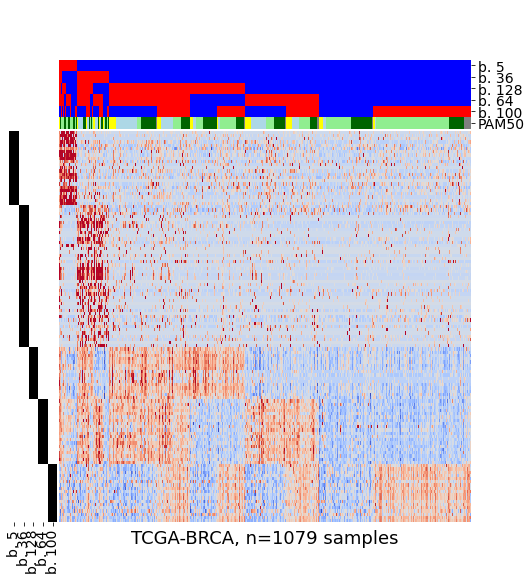

In [31]:
from unpast.unpast.utils.figs import draw_heatmap2
w = 8
fs = 12 # Font size
subt_anno = anno_tcga.loc[:,["PAM50"]]
subt_anno = subt_anno.fillna("NA")
subt_anno.head(3)
top_n = 5

bics = bics_tcga.loc[potentially_novel.head(top_n).sort_values(by="n_samples").index.values, :]

sele_bics = bics.index.values
h = min(max(3,bics.loc[sele_bics,"n_genes"].sum()/5),10)
if w>h:
    cr = max(min(0.015,0.05*h/10),0.05)
else:
    cr = min(max(0.015,0.015*h/10),0.05)
fig, samples, colors = draw_heatmap2(exprs_tcga.copy(),
                    bics.loc[sele_bics,:],
                    annot=subt_anno,
                    color_dict=color_dict,
                  #bicluster_colors="auto",
                  #bicluster_colors="black",
                  bicluster_colors="redblue",
                  figsize = (w,h*0.8), 
                  dendrogram_ratio=(0.1,0.1),
                  colors_ratio=(cr/w*h, cr*1.5),
                  bic_prefix = "b. ",
                  legend_n_cols=0,
                  no_cbar=True,
                  col_labels = False,
                  #highlight_row_labels=highlight_genes,
                  #row_labels = True,
                  no_row_colors = False,
                  cluster_rows=False,
                  #cluster_rows=True,
                  #cluster_columns=True
                 )
ax = fig.ax_heatmap
tmp = ax.set_xlabel("TCGA-BRCA, n=%s samples"%subt_anno.shape[0],fontsize=18)
if h>=8:
    tmp = ax.set_yticklabels(ax.get_yticklabels(),fontsize=7)

tmp = fig.ax_col_colors.set_yticklabels(fig.ax_col_colors.get_yticklabels(),fontsize=14)
tmp = fig.ax_row_colors.set_xticklabels(fig.ax_row_colors.get_xticklabels(),fontsize=14)

### same genes but clustered

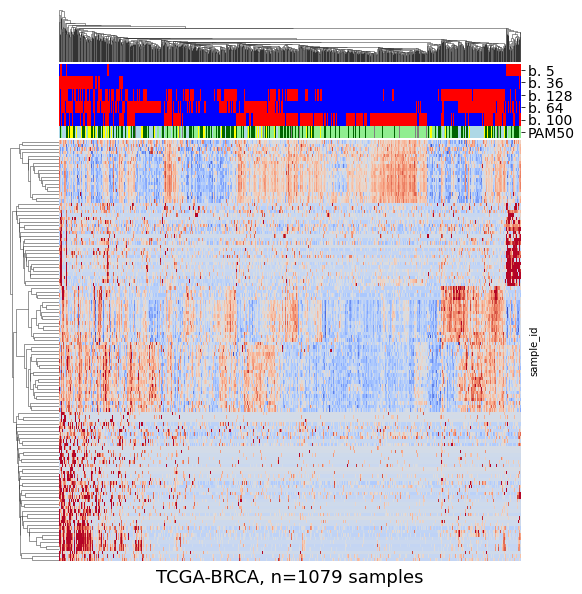

In [32]:
df = colors[0].copy()
d = {"white":0,"black":1}
df = df.applymap(lambda x:d[x])
df = df[df.sum(axis=1)>0]
df = df.sort_values(by=list(df.columns.values),ascending=False)
fig = sns.clustermap(fig.data2d.loc[list(df.index.values),
                                    samples],
                       col_cluster=True,#row_cluster=True,
                       cmap=sns.color_palette("coolwarm", as_cmap=True),
                       vmin=-3,vmax=3,
                       xticklabels=False, yticklabels=False,
                       col_colors=colors[1],
                       #row_colors=colors[0],
                       figsize=(w,h*0.8), 
                       dendrogram_ratio=(0.1,0.1),
                       colors_ratio=(cr/w*h, cr*1.5),)
fig.cax.set_visible(False)
ax = fig.ax_heatmap
tmp = ax.set_xlabel("TCGA-BRCA, n=%s samples"%subt_anno.shape[0],fontsize=18)
tmp = fig.ax_col_colors.set_yticklabels(fig.ax_col_colors.get_yticklabels(),fontsize=14)
#tmp = fig.ax_row_colors.set_xticklabels(fig.ax_row_colors.get_xticklabels(),fontsize=14)

In [34]:
### legend

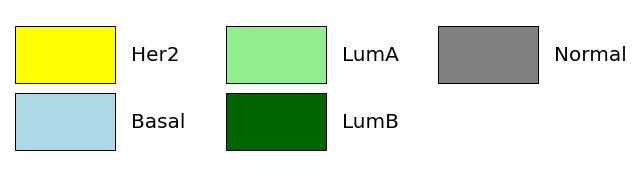

In [35]:
from matplotlib.patches import Patch

legend_elements = []
for subt in color_dict["PAM50"].keys():
    p = Patch(facecolor=color_dict["PAM50"][subt], edgecolor='black', label=subt)
    legend_elements.append(p)

# Create the figure
fig, ax = plt.subplots(figsize = (3,3))
legend = ax.legend(
    handles=legend_elements,
    loc='center',
    ncol=3,
    handlelength=5,
    handleheight=4,
    title='',  # Legend title
    fontsize=20  # Legend items font size
)

legend.get_frame().set_alpha(0)

legend.set_title('', prop={'size': 22})

ax.axis('off')

plt.show()


# top-5 biclusters with the highest number of shared genes

In [109]:
from unpast.unpast.utils.figs import draw_heatmap2

In [110]:
import seaborn as sns

colors: ['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc']


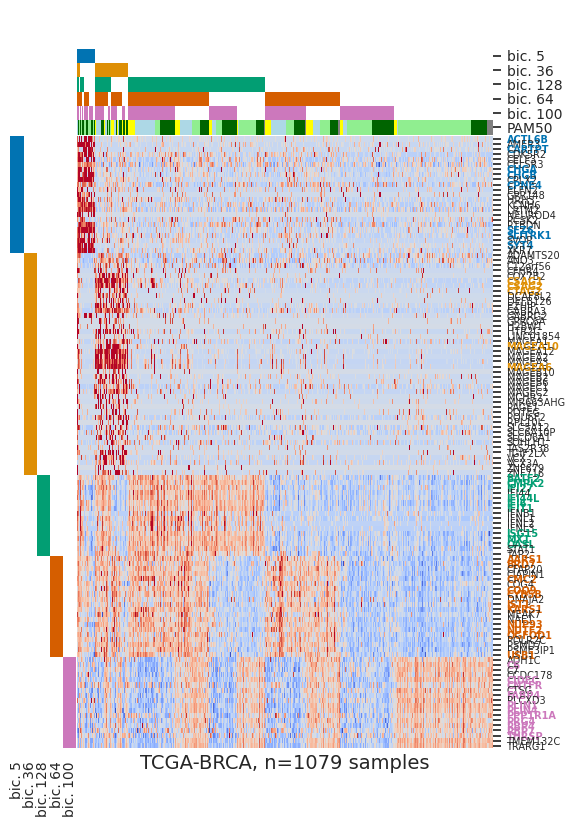

In [115]:
subt_anno = anno_tcga.loc[:,["PAM50"]]
subt_anno = subt_anno.fillna("NA")
subt_anno.head(3)

bics = bics_tcga.loc[potentially_novel.head(top_n).sort_values(by="n_samples").index.values, :]
#bics["genes"] = bics["genes"].apply(lambda row: set([x for x in row if x in gene_list]))
#bics["genes_up"] = bics["genes_up"].apply(lambda row: set([x for x in row if x in gene_list]))
#bics["genes_down"] = bics["genes_down"].apply(lambda row: set([x for x in row if x in gene_list]))
w, h = 6,8
sns.set(font_scale=0.5)
fig, samples, colors = draw_heatmap2(exprs_tcga,
                    bics,
                    figsize = (w,h), 
                    colors_ratio=(cr/w*h*1.3, cr*1.3),
                    dendrogram_ratio=(0.05,0.05),
                    annot=subt_anno,
                    color_dict=color_dict,
                    bicluster_colors="auto",
                    col_labels = False,
                    row_labels =True,
                    no_row_colors = False,
                    legend_n_cols=0,
                    no_cbar = True,
                    cluster_rows=False,
                    highlight_row_labels=list(gene_list),
                   bic_prefix="bic. ",xlabel = "samples (TCGA-BRCA)")
                
fname = "reproduced_5bics_TCGA"
tmp = fig.ax_col_colors.set_yticklabels(fig.ax_col_colors.get_yticklabels(),fontsize=10)
tmp = fig.ax_row_colors.set_xticklabels(fig.ax_row_colors.get_xticklabels(),fontsize=10)
ax = fig.ax_heatmap
tmp = ax.set_xlabel("TCGA-BRCA, n=%s samples"%subt_anno.shape[0], fontsize=14)
if h>=8:
    tmp = ax.set_yticklabels(ax.get_yticklabels(),fontsize=7)
#plt.savefig("img/Supplementary/reproduced_5bics/"+fname+".svg",format="svg")
#plt.savefig("img/Supplementary/reproduced_5bics/"+fname+".png",format="png", dpi = 1000)
#plt.savefig("img/Supplementary/reproduced_5bics/"+fname+".pdf",format="pdf")
plt.show()

colors: ['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc']


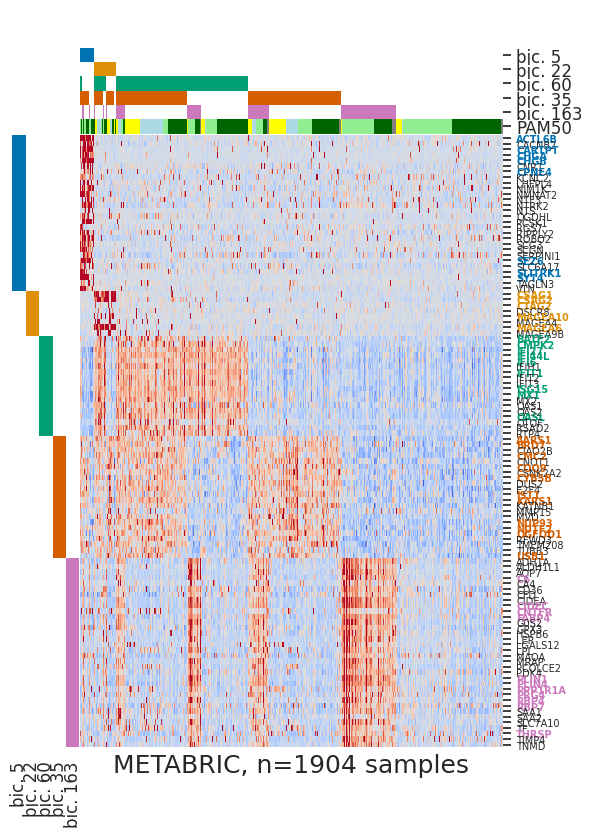

In [116]:
subt_anno = anno_meta.loc[:,["PAM50"]]
subt_anno = subt_anno.fillna("NA")
subt_anno.head(3)

bics = bics_meta.loc[potentially_novel.head(top_n).sort_values(by="n_samples")["bm_id"].values, :]
 
sns.set(font_scale=0.5)
fig, samples, colors =draw_heatmap2(exprs_meta,
                    bics,
                    figsize = (w,h), 
                    colors_ratio=(cr/w*h*1.3, cr*1.3),
                    dendrogram_ratio=(0.05,0.05),
                    annot=subt_anno,
                    color_dict=color_dict,
                    bicluster_colors="auto",
                    col_labels = False,
                    row_labels =True,
                    no_row_colors = False,
                    legend_n_cols=0,
                    no_cbar = True,
                    cluster_rows=False,
                    highlight_row_labels=list(gene_list),
                   bic_prefix="bic. ",xlabel = "samples (METABRIC)")

tmp = fig.ax_col_colors.set_yticklabels(fig.ax_col_colors.get_yticklabels(),fontsize=12)
tmp = fig.ax_row_colors.set_xticklabels(fig.ax_row_colors.get_xticklabels(),fontsize=12)
ax = fig.ax_heatmap
tmp = ax.set_xlabel("METABRIC, n=%s samples"%subt_anno.shape[0], fontsize=18)
if h>=8:
    tmp = ax.set_yticklabels(ax.get_yticklabels(),fontsize=7)

fname = "reproduced_5bics_METABRIC"
#plt.savefig("img/Supplementary/reproduced_5bics/"+fname+".svg",format="svg")
#plt.savefig("img/Supplementary/reproduced_5bics/"+fname+".png",format="png", dpi = 1000)
#plt.savefig("img/Supplementary/reproduced_5bics/"+fname+".pdf",format="pdf")
plt.show()

In [79]:
df = potentially_novel.sort_values(by="n_shared_genes",ascending=False)
df["id_TCGA"] = df.index.values
df["id_METABRIC"] = df["bm_id"]
df["Jaccard"] = df["J"]
df["n_shared"] = df["shared_genes"].apply(lambda row:len(row))
df["shared"] = df["shared_genes"].apply(lambda row:" ".join(sorted(row)))
df["union"] = df.apply(lambda row: row['genes']|row['bm_genes'],axis=1)
df["n_union"] = df["union"].apply(lambda row:len(row))
df["union"] = df.apply(lambda row:" ".join(sorted(row['union'])),axis=1)
df["n_genes_TCGA"] = df["n_genes"]
df["genes_TCGA"] = df["genes"].apply(lambda row:" ".join(sorted(row)))
df["n_genes_METABRIC"] = df["bm_n_genes"]
df["genes_METABRIC"] = df["bm_genes"].apply(lambda row:" ".join(sorted(row)))
df["n_samples_TCGA"] = df["n_samples"]
df["samples_TCGA"] = df["samples"].apply(lambda row:" ".join(sorted(row)))
df["n_samples_METABRIC"] = df["bm_n_samples"]
df["samples_METABRIC"] = df["bm_samples"].apply(lambda row:" ".join(sorted(row)))
cols = ["id_TCGA","id_METABRIC","Jaccard","n_shared","shared","n_union","union",
       "n_genes_TCGA","genes_TCGA","n_genes_METABRIC","genes_METABRIC",
       "n_samples_TCGA","samples_TCGA","n_samples_METABRIC","samples_METABRIC"]
df = df.loc[:,cols]
df = df.sort_values(by=["n_shared","n_union"],ascending=[False,False])
df.index = range(df.shape[0])
df.to_csv('Supplementary/TableSX_potentially_novel.tsv',sep = "\t")
df

,id_TCGA,id_METABRIC,Jaccard,n_shared,shared,n_union,union,n_genes_TCGA,genes_TCGA,n_genes_METABRIC,genes_METABRIC,n_samples_TCGA,samples_TCGA,n_samples_METABRIC,samples_METABRIC
0,100,163,0.268293,11,C6 CIDEC CNTFR FABP4 PLIN1 PLIN4 PPP1R1A PRG4 ...,41,ADH1A ADH1C ALDH1L1 AQP7 C6 C7 CA4 CCDC178 CD3...,18,ADH1C C6 C7 CCDC178 CIDEC CNTFR CTSG FABP4 PLC...,34,ADH1A ALDH1L1 AQP7 C6 CA4 CD36 CFD CIDEA CIDEC...,526,TCGA-3C-AAAU-01 TCGA-3C-AALI-01 TCGA-4H-AAAK-0...,465,MB-0000 MB-0008 MB-0014 MB-0022 MB-0036 MB-004...
1,64,35,0.354839,11,AARS1 BRD7 CMC2 COQ9 CYB5B IST1 KARS1 NUP93 NU...,31,AARS1 BRD7 CFAP20 CIAO2B CIAPIN1 CMC2 CNOT1 CO...,20,AARS1 BRD7 CFAP20 CIAPIN1 CMC2 COG4 COQ9 CYB5B...,22,AARS1 BRD7 CIAO2B CMC2 CNOT1 COQ9 CSNK2A2 CYB5...,492,TCGA-3C-AAAU-01 TCGA-3C-AALI-01 TCGA-3C-AALJ-0...,853,MB-0002 MB-0008 MB-0036 MB-0045 MB-0060 MB-006...
2,128,60,0.36,9,BATF2 CMPK2 IFI27 IFI44L IFI6 IFIT1 ISG15 MX1 ...,25,BATF2 CMPK2 IFI27 IFI44 IFI44L IFI6 IFIH1 IFIT...,16,BATF2 CMPK2 IFI27 IFI44 IFI44L IFI6 IFIT1 IFNB...,18,BATF2 CMPK2 IFI27 IFI44L IFI6 IFIH1 IFIT1 IFIT...,413,TCGA-A1-A0SD-01 TCGA-A1-A0SI-01 TCGA-A2-A04P-0...,658,MB-0006 MB-0008 MB-0039 MB-0045 MB-0048 MB-005...
3,5,5,0.186047,8,ACTL6B CARTPT CHGA CHGB CPNE4 SEZ6 SLITRK1 SYT4,43,ACTL6B AMER3 CACNB2 CARTPT CDK5R2 CELF3 CELSR3...,23,ACTL6B AMER3 CARTPT CDK5R2 CELF3 CELSR3 CHGA C...,28,ACTL6B CACNB2 CARTPT CHGA CHGB CNR1 CPNE4 KCNC...,48,TCGA-3C-AAAU-01 TCGA-A1-A0SK-01 TCGA-A2-A1FV-0...,66,MB-0036 MB-0056 MB-0064 MB-0095 MB-0154 MB-018...
4,36,22,0.106383,5,CSAG1 CSAG2 CTAG2 MAGEA10 MAGEA6,47,ADAMTS20 ANO3 C12orf56 CFHR4 COX7B2 CSAG1 CSAG...,44,ADAMTS20 ANO3 C12orf56 CFHR4 COX7B2 CSAG1 CSAG...,8,CSAG1 CSAG2 CTAG2 DSCR8 MAGEA10 MAGEA4 MAGEA6 ...,93,TCGA-3C-AALI-01 TCGA-A2-A0CY-01 TCGA-A2-A0EV-0...,99,MB-0008 MB-0060 MB-0100 MB-0109 MB-0149 MB-015...
5,63,142,0.142857,4,ELOC MTERF3 MTFR1 SQLE,28,CYC1 DCAF13 DERL1 DSCC1 ELOC EMC2 ENY2 HGH1 LA...,26,CYC1 DCAF13 DERL1 DSCC1 ELOC EMC2 ENY2 HGH1 LA...,6,ELOC MTERF3 MTFR1 RRS1 SQLE TMEM70,439,TCGA-3C-AALJ-01 TCGA-A1-A0SG-01 TCGA-A1-A0SJ-0...,698,MB-0006 MB-0008 MB-0010 MB-0022 MB-0028 MB-003...
6,140,139,0.142857,4,HMGCS2 LRRC31 SHROOM1 SOWAHA,28,ABCC11 ABCC6 ANKFN1 ANKRD34C CLDN25 CYP4A11 CY...,26,ABCC11 ABCC6 ANKFN1 ANKRD34C CLDN25 CYP4A11 CY...,6,FRMPD3 GDF9 HMGCS2 LRRC31 SHROOM1 SOWAHA,537,TCGA-3C-AAAU-01 TCGA-3C-AALJ-01 TCGA-4H-AAAK-0...,492,MB-0010 MB-0014 MB-0022 MB-0035 MB-0046 MB-006...
7,55,18,0.4,4,HOXB-AS3 HOXB4 HOXB5 HOXB6,10,ENTPD3 HOXB-AS3 HOXB1 HOXB3 HOXB4 HOXB5 HOXB6 ...,6,HOXB-AS3 HOXB1 HOXB4 HOXB5 HOXB6 LGALS9B,8,ENTPD3 HOXB-AS3 HOXB3 HOXB4 HOXB5 HOXB6 HOXB7 ...,268,TCGA-3C-AAAU-01 TCGA-3C-AALI-01 TCGA-3C-AALK-0...,348,MB-0022 MB-0056 MB-0095 MB-0109 MB-0121 MB-012...
8,74,35,0.107143,3,KARS1 OGFOD1 RFWD3,28,AARS1 BRD7 CBFB CIAO2B CMC2 CNOT1 COQ9 CSNK2A2...,9,CBFB KARS1 NAE1 NIP7 OGFOD1 PSMD7 RFWD3 SF3B3 ...,22,AARS1 BRD7 CIAO2B CMC2 CNOT1 COQ9 CSNK2A2 CYB5...,443,TCGA-3C-AAAU-01 TCGA-3C-AALI-01 TCGA-3C-AALJ-0...,853,MB-0002 MB-0008 MB-0036 MB-0045 MB-0060 MB-006...
9,114,55,0.1875,3,CALML3 COL17A1 TP63,16,CALML3 COL17A1 DSG3 DST ECRG4 FAT2 KRT14 KRT5 ...,9,CALML3 COL17A1 DSG3 FAT2 KRT14 KRT5 NTF4 TENM2...,10,CALML3 COL17A1 DST ECRG4 MYL7 NSG1 OPRPN PAMR1...,417,TCGA-3C-AAAU-01 TCGA-3C-AALI-01 TCGA-3C-AALJ-0...,458,MB-0000 MB-0045 MB-0046 MB-0048 MB-0050 MB-006...


# Survival analysis
 because only 9 patients in METABRIC and only 19 in TCGA had stage 4, stages 3 and 4 were merged

In [80]:
anno_tcga["is_Lum"] = 0
anno_tcga.loc[anno_tcga["PAM50"].str.contains("Lum"),"is_Lum"] = 1
anno_tcga["is_Her2"] = 0
anno_tcga.loc[anno_tcga["PAM50"]=="Her2","is_Her2"] = 1

anno_meta["is_Lum"] = 0
anno_meta.loc[anno_meta["PAM50"].str.contains("Lum"),"is_Lum"] = 1
anno_meta["is_Her2"] = 0
anno_meta.loc[anno_meta["PAM50"]=="Her2","is_Her2"] = 1


# Evaluate survival for matched biclusters

In [81]:
#bics_matched_tcga = bics_tcga.dropna(subset=["bm_id"]) #
#bics_matched_tcga = bics_matched_tcga.loc[bics_matched_tcga["bm_J"]>0.1,:].loc[bics_matched_tcga["max_ARI"]<0.25,:]
bics_matched_tcga = bics_tcga.loc[potentially_novel.index.values,:]

#bics_matched_meta = bics_meta.dropna(subset=["bm_id"]) #
#bics_matched_meta = bics_matched_meta.loc[bics_matched_meta["bm_J"]>0.1,:].loc[bics_matched_meta["max_ARI"]<0.25,:]
bics_matched_meta = bics_meta.loc[sorted(set(potentially_novel["bm_id"].values)),:]

print(bics_matched_tcga.shape[0], bics_matched_meta.shape[0])

34 32


In [82]:
from utils.eval import  add_survival

covariates = ["age","stage_2","stage_34"] # bc only 9 patients with stage 4 in METABRIC and only 19 in TCGA

bics_matched_tcga = add_survival(bics_matched_tcga, anno_tcga, event= "OS", surv_time ="OS.time",covariates = covariates)
#bics_d = add_survival(bics_d, anno_d, event= "DFI",covariates = covariates)
#bics_d = add_survival(bics_d, anno_d, event= "PFI",covariates = covariates)
#bics_d.loc[bics_d["OS.p_value_BH"]<0.1,:].sort_values(by="OS.p_value")

bics_matched_meta = add_survival(bics_matched_meta, anno_meta, event= "OS", surv_time ="OS.time",covariates = covariates)
#bics_v.loc[bics_v["OS.p_value_BH"]<0.1,:].sort_values(by="OS.p_value")

In [83]:
col = "OS.LogR_p_value_BH"#"OS.p_value_BH" #"OS.LogR_p_value_BH" # 
d = bics_matched_tcga.sort_values("OS.p_value").loc[:,["SNR","genes","direction", "OS.HR","max_ARI","OS.p_value","OS.LogR_p_value","OS.p_value_BH","OS.LogR_p_value_BH","bm_id","bm_J"]]
d.loc[d[col]<0.05,:]#.dropna(subset=["bm_id"])

,SNR,genes,direction,OS.HR,max_ARI,OS.p_value,OS.LogR_p_value,OS.p_value_BH,OS.LogR_p_value_BH,bm_id,bm_J
24,1.918735,"{HOXC11, HOTAIR, HOXC13, HOXC10, MNX1}",DOWN,0.562963,0.030148,0.009589,0.002729,0.163019,0.046395,124,0.25
171,1.406125,"{TUBA3D, TUBA3C, TUBA3E}",UP,0.662502,0.066814,0.032460,0.002077,0.209806,0.046395,85,0.5


In [84]:
" ".join(sorted(bics_tcga.loc[24,"genes"]))

'HOTAIR HOXC10 HOXC11 HOXC13 MNX1'

In [85]:
" ".join(sorted(bics_meta.loc[124,"genes"]))

'HOTAIR HOXC10 HOXC9 IGSF5 SIX1'

In [86]:
d2 = bics_matched_meta.sort_values("OS.p_value").loc[:,["SNR", "genes","direction", "OS.HR","max_ARI","OS.p_value","OS.LogR_p_value","OS.p_value_BH","OS.LogR_p_value_BH","bm_id","bm_J"]]
d2.loc[d2[col]<0.05,:]

,SNR,genes,direction,OS.HR,max_ARI,OS.p_value,OS.LogR_p_value,OS.p_value_BH,OS.LogR_p_value_BH,bm_id,bm_J
55,1.518854,"{MYL7, OPRPN, NSG1, DST, ECRG4, PAMR1, TP63, P...",UP,0.785343,0.238485,0.011929,1.619555e-09,0.292547,5.182575e-08,114,0.1875
85,1.477079,"{TUBA3D, LEF1, TUBA3C, CITED1, PDZK1, TUBA3E}",UP,0.792649,0.077485,0.025842,4.032849e-04,0.292547,6.452558e-03,171,0.5
124,1.423982,"{HOXC9, IGSF5, HOTAIR, HOXC10, SIX1}",UP,1.092608,0.043457,0.219306,4.980221e-03,0.445069,4.098015e-02,24,0.25
172,1.319622,"{SCGB1D2, BPIFB2, SCGB2A1, ASRGL1, KAZALD1, PE...",UP,1.055001,0.048412,0.487279,5.122519e-03,0.623717,4.098015e-02,87,0.285714


In [87]:
d.loc[[114,87],:]

,SNR,genes,direction,OS.HR,max_ARI,OS.p_value,OS.LogR_p_value,OS.p_value_BH,OS.LogR_p_value_BH,bm_id,bm_J
114,1.498005,"{NTF4, FAT2, KRT5, TENM2, COL17A1, TP63, KRT14...",DOWN,1.277130,0.144174,0.168725,0.022201,0.432759,0.150965,55,0.1875
87,1.529873,"{SCGB1D2, SCGB2A1}",UP,0.963118,0.061573,0.827533,0.339107,0.852610,0.549031,172,0.285714


In [88]:
#add_survival(bics_tcga.loc[[92,68],:], anno_tcga, event= "OS", surv_time ="OS.time",covariates = covariates)

In [89]:
all_genes= list(exprs_meta.index.values)
import random 
" ".join(random.sample(all_genes,100))

'IL6R NHS ADGRL1 TMEM187 CEBPG NRN1 CD63 RNF39 METTL21EP DCUN1D1 TNFAIP8L3 TWNK DDC TYR NAA40 GARNL3 RTP1 OTUB1 KIR2DL1 RAB11FIP5 CLGN IGSF3 GPAT4 DDX52 DNAI3 ZNF496 TERC ODAD4 SHISA6 ZNF74 SPOCD1 CFAP210 ANKRD55 ORM1 NAAA FPR2 TNF MAP3K11 RAB26 ACSL6 CYP1A1 CYTH2 NDUFV1 WDR62 NTRK1 DHX37 DYNLL1 GFM2 VIPR1 SH3RF3 SIRT1 VASN DBN1 PRKX STAB2 MRTFB ZBTB17 KNCN PDZD3 ASB6 TRIM29 PLCH2 HS1BP3 OTOL1 ENTPD1 TNXB ADPRS TIPRL PDE7B EFCAB14 STAB1 WRN ASPN TANGO2 SLC25A48 FRRS1L MBD2 HOXD9 DYDC1 FABP1 WWC2-AS2 MUC22 PRKACB KLHL8 PLEC GGT1 SELE DACT1 EI24 LGALS12 PGAP1 ZIK1 PAN2 ITM2C HSPB8 LCE2C IER5L LOC284933 ZNF501 MCM6'

In [90]:
t_i = 92# 24 # 171 # 92 # 68
m_i = 109# 124 # #85 109 # 95

g_t = sorted(bics_tcga.loc[t_i,"genes"])#+["MKI67","AURKA","ESR1","GATA3"]
" ".join(g_t)

'ADIPOR2 AGTR1 ASB15 ASIC2 BMPR1B CCDC196 CGA COX6C CPEB2-DT CST5 DIO1 ELP2 GPR139 GRM3 HNF1A HSPB8 INSYN2A KCNJ3 MIR2052HG MRPS30 MYCBPAP MYOG MYT1 NBPF22P POTEH PRLH RGS22 RP1 SIAH2 SLC39A6 SPINK4 TEX14 WDR72'

In [91]:
g_m = sorted(bics_meta.loc[m_i,"genes"])#+["MKI67","AURKA","ESR1","GATA3"]
" ".join(g_m)

'ARTN COX6C DIO1 ECM1 INSYN2A KCNE4 KCNH1 KISS1R MISP ODAD3 RGS22 SLC16A6 SLC27A2 SPINK4 SYT13 TNFRSF18'

In [92]:
g_shared = sorted(set(g_t).intersection(g_m))
g_union =  sorted(set(g_t).union(g_m))
print("shared:"," ".join(g_shared))
print("union:"," ".join(g_union))

shared: COX6C DIO1 INSYN2A RGS22 SPINK4
union: ADIPOR2 AGTR1 ARTN ASB15 ASIC2 BMPR1B CCDC196 CGA COX6C CPEB2-DT CST5 DIO1 ECM1 ELP2 GPR139 GRM3 HNF1A HSPB8 INSYN2A KCNE4 KCNH1 KCNJ3 KISS1R MIR2052HG MISP MRPS30 MYCBPAP MYOG MYT1 NBPF22P ODAD3 POTEH PRLH RGS22 RP1 SIAH2 SLC16A6 SLC27A2 SLC39A6 SPINK4 SYT13 TEX14 TNFRSF18 WDR72


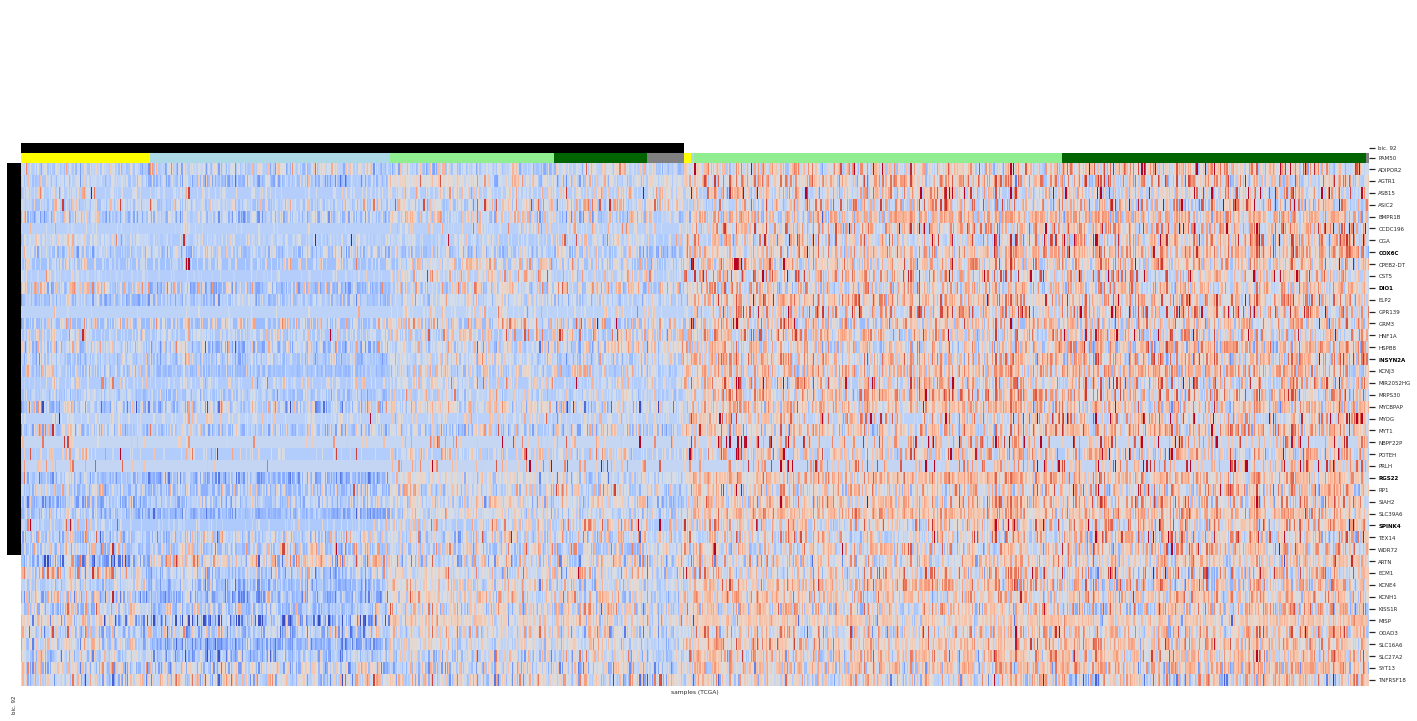

In [93]:
#import seaborn as sns
#sns.clustermap(exprs_tcga.loc[g_union,:],vmin=-3,vmax=3)
subt_anno = anno_tcga.loc[:,["PAM50"]]
subt_anno = subt_anno.fillna("NA")
e = exprs_tcga.loc[g_union,:]
tmp = draw_heatmap2(e,
                   bics_tcga.loc[[t_i],:],
                    figsize = (20,10),
                    colors_ratio=(0.01,0.015),
                    annot=subt_anno,
                    color_dict=color_dict,
                    bicluster_colors="black",
                   col_labels = False,
                    row_labels =True,
                   no_row_colors = False,
                   no_cbar = True,cluster_rows=False,
                    plot_bg_genes = True,
                   highlight_row_labels=list(g_shared),
                   bic_prefix="bic. ",xlabel = "samples (TCGA)")


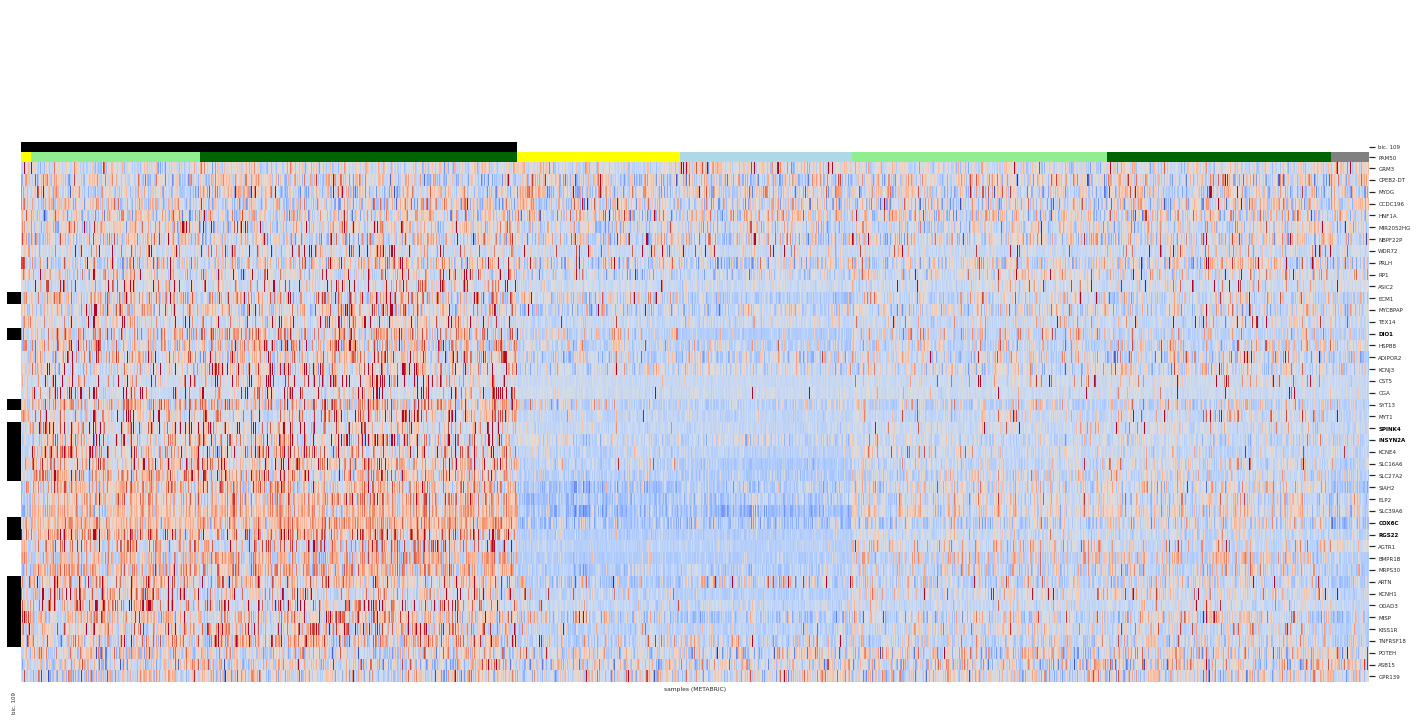

In [94]:
subt_anno = anno_meta.loc[:,["PAM50"]]
subt_anno = subt_anno.fillna("NA")
e = exprs_meta.loc[list(set(g_union).difference(set(['GPR160', 'TMEM45B']))),:]
tmp = draw_heatmap2(e,
                   bics_meta.loc[[m_i],:],
                    figsize = (20,10),
                    colors_ratio=(0.01,0.015),
                    annot=subt_anno,
                    color_dict=color_dict,
                    bicluster_colors="black",
                   col_labels = False,
                    row_labels =True,
                   no_row_colors = False,
                   no_cbar = True,cluster_rows=True,
                    plot_bg_genes = True,
                   highlight_row_labels=list(g_shared),
                   bic_prefix="bic. ",xlabel = "samples (METABRIC)")


# Survival for PAM50 subtypes
Luminal, lumA and Her2 are associated with OS

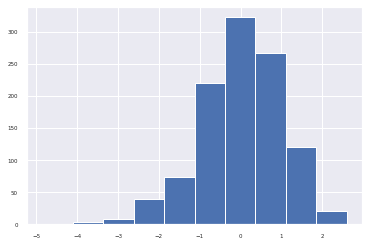

In [95]:
tmp = plt.hist(exprs_tcga.loc["MKI67"].values)

In [96]:
bics_meta[bics_meta["genes"].apply(lambda x: "AURKA" in x)]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,max_ARI,bm_id,bm_J
id,,,,,,,,,,,,,,
78,1.483775,138,748,"{PRELID3A, HROB, KIFC1, FEN1, GGH, BLM, EIF2S2...","{MB-4324, MB-5511, MB-4660, MB-2957, MB-4591, ...","{PRELID3A, HROB, KIFC1, FEN1, GGH, BLM, EIF2S2...",{},"{2561, 2562, 10242, 9732, 13321, 10260, 5145, ...","{4, 5, 8, 13, 17, 18, 19, 20, 24, 30, 32, 34, ...",UP,5,0.260489,40,0.072993


In [97]:
bics_tcga[bics_tcga["genes"].apply(lambda x: "AURKA" in x)]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,max_ARI,bm_id,bm_J
id,,,,,,,,,,,,,,
125,1.474226,4,495,"{AURKA, GINS1, CCNB1, HMGB3}","{TCGA-E9-A1NF-01, TCGA-B6-A0WT-01, TCGA-GM-A2D...",{},"{AURKA, GINS1, CCNB1, HMGB3}","{2240, 5634, 6427, 1237}","{3, 4, 5, 6, 8, 9, 11, 12, 13, 20, 21, 27, 31,...",DOWN,4,0.445852,None,0


In [98]:
df_subt = {}
for subt in ["Luminal","LumA","LumB","Basal","Her2","Normal"]:
    df_subt[subt]={"samples":subts_tcga[subt], "n_samples":len(subts_tcga[subt])}
df_subt = pd.DataFrame.from_dict(df_subt).T
df_subt = add_survival(df_subt, anno_tcga, event= "OS", surv_time ="OS.time",
                       covariates = covariates)
df_subt.loc[:,["OS.HR","n_samples","OS.p_value","OS.LogR_p_value","OS.p_value_BH"]]

,OS.HR,n_samples,OS.p_value,OS.LogR_p_value,OS.p_value_BH
Luminal,0.568896,744,0.002060,0.151066,0.006179
LumA,0.536412,426,0.000955,0.003690,0.005732
LumB,1.133933,318,0.491265,0.081024,0.491265
Basal,1.368162,195,0.165345,0.965264,0.248018
Her2,1.765565,108,0.023793,0.155984,0.047586
Normal,1.610776,32,0.221018,0.127548,0.265221


In [99]:
df_subt = {}
for subt in ["Luminal","LumA","LumB","Basal","Her2","Normal"]:
    df_subt[subt]={"samples":subts_meta[subt], "n_samples":len(subts_meta[subt])}
df_subt = pd.DataFrame.from_dict(df_subt).T
df_subt = add_survival(df_subt, anno_meta, event= "OS", surv_time ="OS.time",
                       covariates = covariates)
df_subt.loc[:,["OS.HR","n_samples","OS.p_value","OS.LogR_p_value","OS.p_value_BH"]]

,OS.HR,n_samples,OS.p_value,OS.LogR_p_value,OS.p_value_BH
Luminal,0.711997,1362,2.476265e-05,1.991318e-02,0.000074
LumA,0.735102,598,1.508975e-04,1.161344e-07,0.000302
LumB,1.005606,764,9.396124e-01,1.878228e-03,0.939612
Basal,1.106062,244,3.791830e-01,4.346016e-01,0.568774
Her2,1.639146,244,7.346678e-07,2.761415e-06,0.000004
Normal,0.970063,54,8.961299e-01,3.506197e-01,0.939612


# Survival for bicluster interaction 

In [100]:
def bic_interactions(bics,all_samples,min_n_samples=10):
    new_groups = {}
    for i1 in range(bics.shape[0]):
        b1 = bics.index.values[i1]
        s1 = bics.loc[b1,"samples"]
        #s1_= all_samples.difference(s1)
        for i2 in range(i1+1,bics.shape[0]):
            b2 = bics.index.values[i2]
            s2 = bics.loc[b2,"samples"]
            #s2_= all_samples.difference(s2)
            new_groups[str(b1)+"_and_"+str(b2)] = s1.intersection(s2)
            if len(new_groups[str(b1)+"_and_"+str(b2)])>= min_n_samples:
                new_groups[str(b1)+"_minus_"+str(b2)] = s1.difference(s2)
                new_groups[str(b2)+"_minus_"+str(b1)] = s2.difference(s1)
            new_groups["not_"+str(b1)+"_"+str(b2)] = all_samples.difference(s1).difference(s2)
    new_groups = pd.DataFrame.from_dict({"samples":pd.Series(new_groups)})
    new_groups["n_samples"] = new_groups["samples"].apply(lambda x: len(x))
    new_groups = new_groups.loc[new_groups['n_samples']>=min_n_samples,:]
    new_groups = new_groups.loc[new_groups['n_samples']<=(len(all_samples)-min_n_samples),:]
    return new_groups

subts = ["Luminal","Basal","Her2"]
bics = bics_matched_tcga.loc[:,['samples',"n_samples"]].copy()
df_subt = {}
for subt in subts:
    df_subt[subt]={"samples":subts_tcga[subt], "n_samples":len(subts_tcga[subt])}
df_subt = pd.DataFrame.from_dict(df_subt).T
bics = pd.concat([df_subt,bics],axis=0)
all_samples = set(exprs_tcga.columns.values)
bic_pairs_tcga  = bic_interactions(bics,all_samples,min_n_samples=20)
print("TCGA pairs",bic_pairs_tcga.shape[0])

bics = bics_matched_meta.loc[:,:].copy()
df_subt = {}
for subt in subts:
    df_subt[subt]={"samples":subts_meta[subt], "n_samples":len(subts_meta[subt])}
df_subt = pd.DataFrame.from_dict(df_subt).T
bics = pd.concat([df_subt,bics],axis=0)
all_samples = set(exprs_meta.columns.values)
bic_pairs_meta  = bic_interactions(bics,all_samples,min_n_samples=20)
print("METABRIC pairs",bic_pairs_meta.shape[0])

TCGA pairs 2378
METABRIC pairs 1794


In [101]:
bic_pairs_tcga_surv.sort_values(by="OS.p_value_BH").head(30)

NameError: name 'bic_pairs_tcga_surv' is not defined

In [ ]:
bic_pairs_tcga_surv = add_survival(bic_pairs_tcga, anno_tcga, event= "OS", surv_time ="OS.time",covariates = covariates)
bic_pairs_tcga_surv.sort_values(by="OS.p_value_BH")

In [ ]:
bic_pairs_meta_surv = add_survival(bic_pairs_meta, anno_meta, event= "OS", surv_time ="OS.time",covariates = covariates)
bic_pairs_meta_surv.sort_values(by="OS.p_value_BH")

In [ ]:
bic_pairs_meta_surv.loc[["124_minus_85","not_85_124","85_minus_124","85_and_124"],:]

In [ ]:
bic_pairs_meta_surv.sort_values(by="OS.LogR_p_value_BH").head(60).tail(30)

In [ ]:
new_groups_surv.sort_values(by="OS.LogR_p_value_BH")

# Genes from one bicluster are not always highly correlated
### average abs. correlation within each replicated bicluster

In [102]:
corr_data1 = {}
corr_data2 = {}
for i in bm["genes"].index.values:
    gset = bm.loc[i,"genes"]
    if 'TMEM45B' in gset or 'GPR160' in gset:
        gset  = [g for g in gset if g != 'TMEM45B' ]
        gset  = [g for g in gset if g != 'GPR160' ]
        
    r1 = exprs_tcga.loc[gset,:].T.corr().values
    mean_r1 = np.mean(np.abs(r1[np.triu_indices(r1.shape[0], k = 1)]))
    
    gset2 = bm.loc[i,"bm_genes"]
    if 'TMEM45B' in gset2 or 'GPR160' in gset2:
        gset2  = [g for g in gset2 if g != 'TMEM45B' ]
        gset2  = [g for g in gset2 if g != 'GPR160' ]
        
    
    r2 = exprs_meta.loc[gset2,:].T.corr().values
    mean_r2 = np.mean(np.abs(r2[np.triu_indices(r2.shape[0], k = 1)]))
    corr_data1[i] = {"r_TCGA":mean_r1,"r_METABRIC":mean_r2}
    
    shared_genes= bm.loc[i,"shared_genes"]
    
    #print(len(gset), round(mean_r1,2),
    #      len(gset2), round(mean_r2,2), 
    #      " ".join(sorted(shared_genes)))

In [103]:
bm = pd.concat([bm,pd.DataFrame.from_dict(corr_data1).T],axis=1)
r1 = bm.loc[:,["r_TCGA"]].iloc[:,[0]]
r2 = bm.loc[:,["bm_id","r_METABRIC"]]
r2= r2.set_index("bm_id")

In [104]:
import seaborn as sns

In [106]:
sns.reset_defaults()

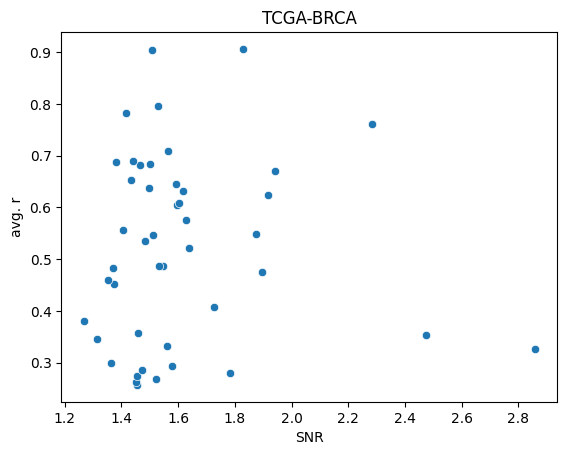

In [107]:
d =pd.concat([bics_tcga.loc[r1.index,["SNR"]],r1],axis=1)
d.columns = ["SNR","avg. r"]
sns.scatterplot(data=d,x="SNR",y="avg. r")
tmp = plt.title("TCGA-BRCA")

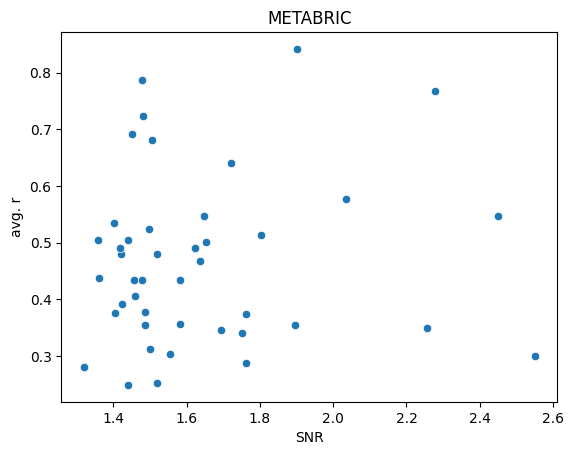

In [108]:
d =pd.concat([bics_meta.loc[r2.index.values,["SNR"]],r2],axis=1)
d.columns = ["SNR","avg. r"]
sns.scatterplot(data=d,x="SNR",y="avg. r")
tmp = plt.title("METABRIC")

# Associated with batch but reproduced between TCGA and METABRIC

### check associations with experimental batches 

In [ ]:
from fisher import pvalue

def associations_with_batches(row, batches, all_samples):
    # report the batch with the strongest association
    samples = row["samples"]
    best_pval = 1
    best_batch = np.nan
    best_j = 0
    best_overlap = 0 
    bm_batch = np.nan
    for b in batches.keys():
        batch = batches[b]
        o = len(samples.intersection(batch))
        bic_only = len(samples.difference(batch))
        batch_only = len(batch.difference(samples))
        bg = len(all_samples.difference(batch).difference(samples))
        p = pvalue(o,bic_only,batch_only,bg ).right_tail
        if p < best_pval:
            best_pval = p
            best_batch = b
            best_j = o/(o+bic_only+batch_only)
            best_overlap = o/(bic_only+o)
            bm_batch = b
    return pd.Series({"batch":best_batch, "batch_pval":best_pval,
                      "batch_j":best_j,"best_overlap":best_overlap,
                     "bm_batch":bm_batch})



df = pd.read_csv("/home/olya/TUM/DESMOND/DESMOND2/data/TCGA-BRCA_GDC.plates.tsv",sep ="\t",index_col=0)['plate']
batches_tcga = {}
for b in set(df):
    batches_tcga[b] = set(df[df==b].index.values)

all_samples_tcga = set(exprs_tcga.columns.values)
assoc_with_batches = bics_tcga.apply(lambda x: associations_with_batches(x, batches_tcga, all_samples_tcga),axis=1)
bics_tcga = pd.concat([bics_tcga,assoc_with_batches],axis=1)
bics_tcga["batch_pval_bonferroni"] = bics_tcga["batch_pval"]* bics_tcga.shape[0]* len(batches_tcga.keys())
assoc_w_batch_tcga = bics_tcga.loc[bics_tcga["batch_pval_bonferroni"] < 0.05,:].index.values
print("Biclusters associated with experimental batch:",len(assoc_w_batch_tcga))
bics_tcga.loc[bics_tcga["batch_pval_bonferroni"] < 0.05,:].sort_metaalues(by = "batch_pval_bonferroni")

df = pd.read_csv("/home/olya/TUM/DESMOND/DESMOND2/data/METABRIC/METABRIC.annotation_meta3.t.tsv",sep ="\t",index_col=0)['cohort']
batches_meta = {}
for b in set(df):
    batches_meta[b] = set(df[df==b].index.values)

all_samples_meta = set(exprs_meta.columns.values)
assoc_with_batches = bics_meta.apply(lambda x: associations_with_batches(x, batches_meta, all_samples_meta),axis=1)
bics_meta = pd.concat([bics_meta,assoc_with_batches],axis=1)
bics_meta["batch_pval_bonferroni"] = bics_meta["batch_pval"]* bics_meta.shape[0]* len(batches_meta.keys())
assoc_w_batch_meta = bics_meta.loc[bics_meta["batch_pval_bonferroni"] < 0.05,:].index
print("Biclusters associated with experimental batch:",len(assoc_w_batch_meta))
bics_meta.loc[bics_meta["batch_pval_bonferroni"] < 0.05,:].sort_metaalues(by = "batch_pval_bonferroni")

In [79]:
bics_d.loc[list(set(best_matches_dv.dropna(subset=["bm_id"]).index).intersection(set(bics_d.loc[bics_d["batch_pval_bonferroni"] < 0.05,:].index.values))),:]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,batch,batch_pval,batch_j,best_overlap,bm_batch,batch_pval_bonferroni,best_match_id,n_shared_genes,shared_genes
id,,,,,,,,,,,,,,,,,,,,
116,1.533932,7,510,"{CHST9, NTF4, SOX10, ANXA3, STAC2, BBOX1, MUC15}","{TCGA-A2-A25F-01, TCGA-A8-A091-01, TCGA-E9-A22...",{},"{CHST9, NTF4, SOX10, ANXA3, STAC2, BBOX1, MUC15}","{733, 9163, 13940, 1332, 9909, 2781, 14270}","{0, 1, 2, 7, 12, 17, 20, 21, 27, 29, 30, 33, 3...",DOWN,5,A00Z,2.623603e-11,0.136364,0.141176,A00Z,2.467499e-07,4,2,"{SOX10, CHST9}"
149,1.498005,9,417,"{CALML3, KRT14, COL17A1, NTF4, DSG3, FAT2, TP6...","{TCGA-A2-A25F-01, TCGA-A8-A08S-01, TCGA-AR-A24...",{},"{CALML3, KRT14, COL17A1, NTF4, DSG3, FAT2, TP6...","{7557, 7530, 1932, 14797, 4945, 3058, 15443, 9...","{0, 1, 2, 7, 16, 18, 22, 26, 27, 28, 29, 36, 3...",DOWN,7,A00Z,1.114800e-09,0.139326,0.148681,A00Z,1.048470e-05,81,3,"{CALML3, TP63, COL17A1}"


In [55]:
bics_v.loc[list(set(best_matches_vd.dropna(subset=["bm_id"]).index).intersection(set(bics_v.loc[bics_v["batch_pval_bonferroni"] < 0.05,:].index.values))),:]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,batch,batch_pval,batch_j,best_overlap,bm_batch,batch_pval_bonferroni,best_match_id,n_shared_genes,shared_genes
id,,,,,,,,,,,,,,,,,,,,
129,1.491855,3,771,"{TPSAB1, CPA3, MS4A2}","{MB-6049, MB-0180, MB-0181, MB-0402, MB-6185, ...","{TPSAB1, CPA3, MS4A2}",{},"{9040, 15474, 3178}","{0, 1, 2, 4, 6, 7, 14, 16, 17, 22, 23, 24, 25,...",UP,5,1.0,7.163645e-24,0.300104,0.374838,1.0,5.122006e-21,214,2,"{CPA3, MS4A2}"
226,1.413485,12,791,"{NDNF, OMD, LRRC17, ECM2, FST, LAMP5, PDGFRL, ...","{MB-4627, MB-6049, MB-0180, MB-0181, MB-0402, ...","{NDNF, OMD, LRRC17, ECM2, FST, LAMP5, PDGFRL, ...",{},"{8128, 9440, 7650, 10624, 13926, 8492, 11725, ...","{0, 1, 2, 3, 5, 6, 7, 14, 15, 23, 25, 26, 27, ...",UP,5,1.0,6.046124e-12,0.261905,0.333755,1.0,4.322979e-09,111,2,"{LAMP5, LRRC17}"
132,1.487282,26,828,"{IFT88, DNAAF3, CHDH, ZMYND12, SLC7A4, CFAP43,...","{MB-0348, MB-4627, MB-0180, MB-0181, MB-4593, ...","{IFT88, DNAAF3, CHDH, ZMYND12, SLC7A4, CFAP43,...",{},"{4100, 2711, 25, 13596, 9762, 12711, 1456, 140...","{1, 8, 9, 10, 13, 21, 22, 26, 28, 29, 33, 37, ...",UP,5,3.0,9.127379e-09,0.320372,0.457729,3.0,6.526076e-06,74,3,"{DNAAF1, DRC3, CACNA1F}"
11,2.159922,15,375,"{C1orf147, C11orf16, COL6A5, PKLR, QSER1, H2BW...","{MB-3088, MB-7151, MB-2614, MB-0485, MB-0054, ...","{C1orf147, C11orf16, COL6A5, PKLR, QSER1, H2BW...",{},"{2851, 4101, 8712, 11848, 1610, 6172, 8206, 30...","{0, 1, 7, 10, 11, 14, 16, 17, 18, 20, 21, 23, ...",UP,5,2.0,2.106715e-54,0.327309,0.434667,2.0,1.506301e-51,153,2,"{C11orf16, DRC7}"
268,1.363242,30,460,"{PRG4, RBP4, SAA1, THRSP, CFD, LGALS12, FABP4,...","{MB-0181, MB-0402, MB-5284, MB-6185, MB-5148, ...","{PRG4, RBP4, SAA1, THRSP, CFD, LGALS12, FABP4,...",{},"{512, 4739, 15364, 14982, 5389, 10638, 1809, 8...","{0, 4, 6, 7, 10, 14, 16, 24, 26, 30, 35, 38, 4...",UP,5,1.0,1.856289e-06,0.197201,0.336957,1.0,1.327247e-03,133,11,"{PRG4, RBP4, THRSP, PPP1R1A, FABP4, CIDEC, PLI..."
173,1.453107,8,496,"{H2BC7, H4C5, H4C8, H2BC4, H3C4, H2AC8, H2BC8,...","{MB-0348, MB-6049, MB-0180, MB-4145, MB-5148, ...","{H2BC7, H4C5, H4C8, H2BC4, H3C4, H2AC8, H2BC8,...",{},"{6147, 6185, 6196, 6165, 6198, 6168, 6169, 6170}","{1, 2, 4, 5, 6, 10, 11, 16, 17, 18, 21, 23, 24...",UP,5,1.0,9.545706e-08,0.210657,0.342742,1.0,6.825180e-05,203,2,"{H2BC4, H4C8}"
175,1.452261,16,450,"{FOSB, EGR2, NR4A1, KLF4, IL6, RGS2, CXCL2, SE...","{MB-0340, MB-6049, MB-0181, MB-0402, MB-5284, ...","{FOSB, EGR2, NR4A1, KLF4, IL6, RGS2, CXCL2, SE...",{},"{4320, 257, 13088, 1095, 12265, 9833, 11724, 1...","{0, 2, 4, 6, 12, 15, 20, 22, 24, 26, 27, 30, 3...",UP,5,1.0,2.286925e-55,0.359124,0.546667,1.0,1.635151e-52,225,2,"{FOSB, NR4A1}"
208,1.424015,28,821,"{PRRT2, ADGRB2, PIP5KL1, ITPKA, MISP3, RAB26, ...","{MB-0348, MB-0180, MB-4593, MB-4145, MB-5284, ...","{PRRT2, ADGRB2, PIP5KL1, ITPKA, MISP3, RAB26, ...",{},"{4481, 16406, 9497, 10905, 14491, 7708, 15003,...","{1, 4, 8, 10, 11, 13, 21, 22, 28, 29, 31, 44, ...",UP,10,3.0,5.245384e-11,0.329060,0.468940,3.0,3.750450e-08,11,4,"{TMPRSS6, CACNA2D2, RHBDL1, PRRT3}"
209,1.423982,5,765,"{HOXC10, SIX1, HOTAIR, HOXC9, IGSF5}","{MB-4627, MB-4593, MB-4145, MB-0884, MB-5148, ...","{HOXC10, SIX1, HOTAIR, HOXC9, IGSF5}",{},"{6505, 6796, 6511, 6483, 13304}","{4, 5, 7, 9, 24, 28, 29, 32, 33, 36, 38, 39, 4...",UP,5,3.0,4.655761e-11,0.319542,0.474510,3.0,3.328869e-08,31,2,"{HOTAIR, HOXC10}"


,samples,OS.p_value,OS.HR,OS.upper_95CI,OS.lower_95CI,OS.LogR_p_value,OS.p_value_BH,OS.LogR_p_value_BH
Luminal,"{TCGA-C8-A1HN-01, TCGA-AO-A126-01, TCGA-AR-A24...",0.002060,0.568896,0.814409,0.397395,0.151066,0.006179,0.187181
Her2,"{TCGA-LL-A5YO-01, TCGA-BH-A18R-01, TCGA-AR-A0T...",0.023793,1.765565,2.890336,1.078498,0.155984,0.047586,0.187181
Normal,"{TCGA-BH-A28O-01, TCGA-A2-A0YK-01, TCGA-AR-A2L...",0.221018,1.610776,3.456231,0.750701,0.127548,0.265221,0.187181
LumA,"{TCGA-BH-A1EY-01, TCGA-AR-A24X-01, TCGA-AC-A3O...",0.000955,0.536412,0.776238,0.370683,0.003690,0.005732,0.022142
Basal,"{TCGA-A2-A0T2-01, TCGA-C8-A134-01, TCGA-BH-A18...",0.165345,1.368162,2.130437,0.878630,0.965264,0.248018,0.965264
LumB,"{TCGA-C8-A1HN-01, TCGA-AO-A126-01, TCGA-AR-A24...",0.491265,1.133933,1.621916,0.792769,0.081024,0.491265,0.187181


,samples,OS.p_value,OS.HR,OS.upper_95CI,OS.lower_95CI,OS.LogR_p_value,OS.p_value_BH,OS.LogR_p_value_BH
Luminal,"{MB-5410, MB-5398, MB-5045, MB-5622, MB-7263, ...",2.476265e-05,0.711997,0.833765,0.608013,1.991318e-02,0.000074,2.986977e-02
LumA,"{MB-5410, MB-5398, MB-5280, MB-3064, MB-4442, ...",1.508975e-04,0.735102,0.861931,0.626936,1.161344e-07,0.000302,6.968065e-07
Normal,"{MB-5238, MB-0220, MB-5453, MB-7187, MB-0519, ...",8.961299e-01,0.970063,1.530986,0.614651,3.506197e-01,0.939612,4.207437e-01
Her2,"{MB-0314, MB-3396, MB-4871, MB-6223, MB-0643, ...",7.346678e-07,1.639146,1.993252,1.347948,2.761415e-06,0.000004,8.284244e-06
Basal,"{MB-5531, MB-4696, MB-5236, MB-5616, MB-4254, ...",3.791830e-01,1.106062,1.384692,0.883499,4.346016e-01,0.568774,4.346016e-01
LumB,"{MB-4702, MB-5045, MB-3525, MB-5622, MB-0585, ...",9.396124e-01,1.005606,1.162097,0.870189,1.878228e-03,0.939612,3.756456e-03


In [83]:
df = bics_d.loc[bics_d["OS.LogR_p_value_BH"]<0.1,:]
df.loc[:,["SNR","n_genes","genes","n_samples","OS.p_value",
          "OS.LogR_p_value_BH",
                                    "OS.p_value_BH",#"DFI.p_value_BH","PFI.p_value_BH",
         #                              "n_shared_genes","shared_genes","best_match_id"
         ]].sort_values(by="OS.p_value")

,SNR,n_genes,genes,n_samples,OS.p_value,OS.LogR_p_value_BH,OS.p_value_BH
90,1.578219,29,"{ZNF385B, RBM24, SLC7A4, ABCC13, LINC02873, CL...",485,0.001399,0.056303,0.06467
234,1.406125,3,"{TUBA3C, TUBA3E, TUBA3D}",390,0.001960,0.056303,0.06467
153,1.494270,50,"{C6orf118, DNAAF6, CDHR4, LMNTD1, C20orf85, ZB...",166,0.005062,0.085659,0.11136


In [70]:
#bics_d.loc[:,[ "OS.p_value_BH","DFI.p_value_BH","PFI.p_value_BH"]].min(axis=1).sort_values()

In [72]:
#s1=  bics_d.loc[56,"samples"]
#len(s1.intersection(subts_d["LumA"]))
#adj_pvals.loc[56,:]

In [90]:
bics_d.loc[149,:]#["SNR","n_genes","genes","n_samples",
                #                    "OS.p_value","OS.p_value_BH", "OS.LogR_p_value_BH",
                #                              "DFI.p_value_BH","PFI.p_value_BH",
                #                       "n_shared_genes","shared_genes","best_match_id"]]#.sort_values(by="OS.p_value")

SNR                                                               1.498005
n_genes                                                                  9
n_samples                                                              417
genes                    {CALML3, KRT14, KRT5, COL17A1, DSG3, TENM2, FA...
samples                  {TCGA-AO-A0J3-01, TCGA-GM-A5PX-01, TCGA-AN-A0F...
genes_up                                                                {}
genes_down               {CALML3, KRT14, KRT5, COL17A1, DSG3, TENM2, FA...
gene_indexes             {7557, 7530, 1932, 14797, 4945, 3058, 15443, 9...
sample_indexes           {0, 1, 2, 7, 16, 18, 22, 26, 27, 28, 29, 36, 3...
direction                                                             DOWN
detected_n_times                                                         7
batch                                                                 A00Z
batch_pval                                                             0.0
batch_j                  

In [89]:
df2 = bics_v.loc[bics_v["OS.p_value_BH"]<0.05,:]
df2.sort_values(by="OS.p_value").loc[:,["SNR","n_genes","genes","n_samples",
                                    "OS.p_value_BH","OS.p_value",
                                      "n_shared_genes","shared_genes","best_match_id"
                                       ]].dropna()

,SNR,n_genes,genes,n_samples,OS.p_value_BH,OS.p_value,n_shared_genes,shared_genes,best_match_id
81,1.539947,8,"{PAMR1, CALML3, MYL7, NSG1, COL17A1, ECRG4, DS...",464,1.221610e-07,2.714689e-09,3,"{TP63, COL17A1, CALML3}",149
136,1.483520,132,"{LRP8, ANLN, KNTC1, PRAME, TROAP, TTK, PLAAT1,...",755,5.504194e-06,2.446308e-07,19,"{LRP8, CDCA7, CCNE1, PRAME, FADS2, FADS1, FOXD...",51
148,1.473962,34,"{CAVIN2, LRRN3, PENK, SCARA5, NRXN2, LHX6, MYH...",519,8.006253e-05,5.337502e-06,4,"{ADH1C, C7, CCDC178, CTSG}",133
16,2.003942,22,"{PNMT, PRODH, PSMB3, NEU4, FBXL20, ORMDL3, GRB...",235,2.366553e-04,2.103602e-05,7,"{PGAP3, MIEN1, STARD3, ERBB2, ORMDL3, PSMD3, G...",29
209,1.423982,5,"{SIX1, HOXC10, IGSF5, HOXC9, HOTAIR}",765,2.390530e-04,2.656144e-05,2,"{HOTAIR, HOXC10}",31
144,1.477079,6,"{TUBA3D, PDZK1, TUBA3E, CITED1, TUBA3C, LEF1}",296,3.016180e-04,4.471601e-05,3,"{TUBA3C, TUBA3E, TUBA3D}",234
226,1.413485,12,"{OMD, FST, MATN3, PDGFRL, PTH1R, ECM2, LAMP5, ...",791,3.016180e-04,4.791963e-05,2,"{LRRC17, LAMP5}",111
185,1.444099,6,"{ZNF385B, ADCY1, ERICH3, PGR, CHST8, EVA1B}",609,3.016180e-04,5.362098e-05,3,"{ERICH3, ZNF385B, ADCY1}",90
121,1.504598,9,"{SHARPIN, ZNF7, EXOSC4, TIGD5, EPPK1, RECQL4, ...",603,7.712914e-04,1.542583e-04,2,"{SLC52A2, CYC1}",228
132,1.487282,26,"{SREBF1, SLC7A4, SPATA18, DNAAF1, BMERB1, ZMYN...",828,2.985133e-03,6.633628e-04,3,"{CACNA1F, DRC3, DNAAF1}",74


In [84]:
#df2.sort_values(by="OS.p_value")

In [144]:
sele = set(df.index.values).intersection(set(df2['best_match_id'].values))
print(sele)
df.loc[list(sele),:]

{11, 31}


,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,...,best_match_id,n_shared_genes,shared_genes,OS.p_value,OS.HR,OS.upper_95CI,OS.lower_95CI,OS.LogR_p_value,OS.p_value_BH,OS.LogR_p_value_BH
11,2.159922,15,375,"{COL6A5, MAGEH1, C1orf147, BCL2A1, QSER1, PKLR...","{MB-3453, MB-3006, MB-3329, MB-2847, MB-7200, ...","{COL6A5, MAGEH1, C1orf147, BCL2A1, QSER1, PKLR...",{},"{2851, 4101, 11848, 8712, 1610, 7228, 3087, 82...","{0, 1, 7, 10, 11, 14, 16, 17, 18, 20, 21, 23, ...",UP,...,153,2,"{DRC7, C11orf16}",0.002265,0.783966,0.916546,0.670564,0.002206,0.008305,0.008090
31,1.770238,21,273,"{GLYATL2, AKR1B15, HSD17B2, CLCA2, ZP2, CXCL17...","{MB-0238, MB-5351, MB-3453, MB-5208, MB-3272, ...","{GLYATL2, AKR1B15, HSD17B2, CLCA2, ZP2, CXCL17...",{},"{4741, 138, 4491, 10382, 2831, 3477, 10012, 13...","{1536, 513, 1538, 1027, 1032, 521, 522, 9, 154...",UP,...,280,4,"{HSD17B2, CLCA2, ATP13A5, ZP2}",0.001155,1.309862,1.541444,1.113072,0.001116,0.005164,0.004985


In [145]:
" ".join(sorted(bics_d.loc[90,"shared_genes"]))
#bics_d.loc[65,:]

'ADCY1 ERICH3 ZNF385B'

In [146]:
sele2 = set(df2.index.values).intersection(set(df['best_match_id'].values))
print(sele2)
sele1 = df2.loc[list(sele2),"best_match_id"].values
df2.loc[list(sele2),:]

{11, 31}


,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,...,best_match_id,n_shared_genes,shared_genes,OS.p_value,OS.HR,OS.upper_95CI,OS.lower_95CI,OS.LogR_p_value,OS.p_value_BH,OS.LogR_p_value_BH
11,2.159922,15,375,"{COL6A5, MAGEH1, C1orf147, BCL2A1, QSER1, PKLR...","{MB-3453, MB-3006, MB-3329, MB-2847, MB-7200, ...","{COL6A5, MAGEH1, C1orf147, BCL2A1, QSER1, PKLR...",{},"{2851, 4101, 11848, 8712, 1610, 7228, 3087, 82...","{0, 1, 7, 10, 11, 14, 16, 17, 18, 20, 21, 23, ...",UP,...,153,2,"{DRC7, C11orf16}",0.002265,0.783966,0.916546,0.670564,0.002206,0.008305,0.008090
31,1.770238,21,273,"{GLYATL2, AKR1B15, HSD17B2, CLCA2, ZP2, CXCL17...","{MB-0238, MB-5351, MB-3453, MB-5208, MB-3272, ...","{GLYATL2, AKR1B15, HSD17B2, CLCA2, ZP2, CXCL17...",{},"{4741, 138, 4491, 10382, 2831, 3477, 10012, 13...","{1536, 513, 1538, 1027, 1032, 521, 522, 9, 154...",UP,...,280,4,"{HSD17B2, CLCA2, ATP13A5, ZP2}",0.001155,1.309862,1.541444,1.113072,0.001116,0.005164,0.004985


In [147]:
" ".join(sorted(df2.loc[132,"genes"]))
#df.loc[7,"best_match_id"]
#" ".join(sorted(df2.loc[22,"genes"]))
#df.loc[22,"best_match_id"]

'ABAT ADPRHL1 BMERB1 CACNA1F CCDC153 CFAP119 CFAP43 CFAP69 CFAP70 CHDH DNAAF1 DNAAF11 DNAAF3 DRC3 IFT88 IGFALS METTL25B NPAS1 RTN2 SLC49A3 SLC7A4 SPATA18 SREBF1 WDR31 ZMYND10 ZMYND12'

### Test OS-associated biclusters from one dataset in the other 

In [148]:
from sklearn.cluster import AgglomerativeClustering,KMeans,SpectralClustering
from sklearn.mixture import GaussianMixture

def get_samples(data,method = "kmeans"):
    if method == "ward":
        model = AgglomerativeClustering(n_clusters=2, linkage='ward')
    elif method == "kmeans":
        model = KMeans(n_clusters=2,n_init=5)
    elif method == "spectral":
        model = SpectralClustering(n_components=2)
    elif method == "GMM":
        model = GaussianMixture(n_components=2, init_params="kmeans")
        
    labels = model.fit_predict(data.T)
    samples= data.columns[np.array(labels,dtype=bool)]
    if len(samples)>data.shape[1]/2:
        samples  = set(data.columns.values).difference(set(samples))
    return set(samples)

#### TCGA -> METARBIC

In [196]:
df = bics_d.loc[bics_d["OS.p_value_BH"]<0.05,:].sort_values(by = "OS.p_value_BH")
df.loc[:,["genes","n_genes","n_samples","direction","best_match_id", "OS.p_value_BH", "DFI.p_value_BH", "PFI.p_value_BH"]]

,genes,n_genes,n_samples,direction,best_match_id,OS.p_value_BH,DFI.p_value_BH,PFI.p_value_BH
56,"{ZIC2, ZIC5, LHX1}",3,315,UP,None,0.001029,0.349498,0.224789


ValueError: Linkage must be computed on at least two observations.

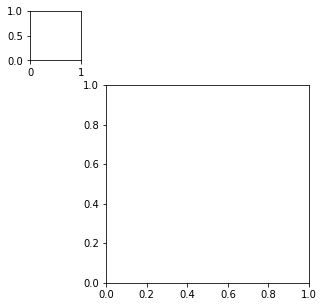

In [151]:
import seaborn as sns
m = pd.DataFrame(data= [], index=exprs_d.columns)
for row1 in df.iterrows():
    s1 = row1[1]["samples"]
    i1 = row1[0]
    m[i1] = 0
    m.loc[list(s1),i1] =1
sns.clustermap(m.corr(),figsize=(5,5),annot= True,
               vmin=-1,vmax=1, cmap = sns.color_palette("coolwarm", as_cmap=True))

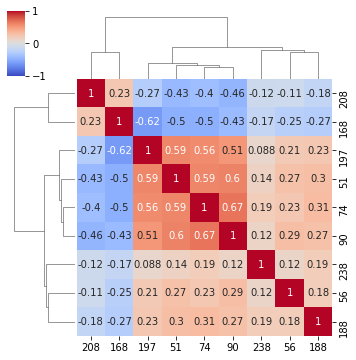

In [32]:
import seaborn as sns
J ={} 
m = pd.DataFrame(data= [], index=exprs_d.columns)
for row1 in df.iterrows():
    s1 = row1[1]["samples"]
    i1 = row1[0]
    J[i1] = {}
    m[i1] = 0
    m.loc[list(s1),i1] =1
    for row2 in df.iterrows():
        i2 = row2[0]
        s2 = row2[1]["samples"]
        if i1 != i2:
            o = s1.intersection(s2)
            u = s1.union(s2)
            J[i1][i2] = len(o)/len(u)
        else:
            J[i1][i2] = 1
J = pd.DataFrame.from_dict(J)
#sns.clustermap(J,figsize=(5,5),annot= True)
sns.clustermap(m.corr(),figsize=(5,5),annot= True,
               vmin=-1,vmax=1, cmap = sns.color_palette("coolwarm", as_cmap=True))

In [197]:
# make biclusters based on gene sets
df2 = {}
for i in df.index:
    gset = df.loc[i,"genes"]
    #if i == 51:
    #    gset = set([ 'HOXB-AS3', 'HOXB3', 'HOXB4', 'HOXB5', 'HOXB6'])
    s0 =  get_samples(exprs_v.loc[list(set(exprs_v.index).intersection(set(gset))),:],method="kmeans")
    df2[i] =  {"genes":gset,"samples":s0,"n_genes":len(gset),"n_samples":len(s0)}
df2 = pd.DataFrame.from_dict(df2).T
df2 = add_survival(df2, anno_v, event= "OS", surv_time ="OS.time",covariates = covariates)
df2.sort_values(by = "OS.p_value")

,genes,n_genes,n_samples,samples,OS.HR,OS.LogR_p_value,OS.lower_95CI,OS.p_value,OS.upper_95CI,OS.p_value_BH,OS.LogR_p_value_BH
56,"{ZIC2, ZIC5, LHX1}",3,468,"{MB-5490, MB-0223, MB-6164, MB-3272, MB-6288, ...",1.388685,7.781182e-07,1.218378,8.704140e-07,1.582797,8.704140e-07,7.781182e-07


#### METARBIC -> TCGA

ValueError: Linkage must be computed on at least two observations.

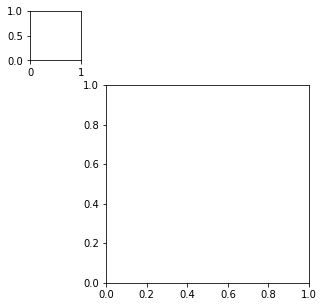

In [95]:
m = pd.DataFrame(data= [], index=exprs_v.columns)
for row1 in df2.iterrows():
    s1 = row1[1]["samples"]
    i1 = row1[0]
    m[i1] = 0
    m.loc[list(s1),i1] =1
sns.clustermap(m.corr(),figsize=(5,5),annot= True,
               vmin=-1,vmax=1, cmap = sns.color_palette("coolwarm", as_cmap=True))

In [199]:
df = bics_v.loc[bics_v["OS.p_value_BH"]<0.05,:].sort_values(by = "OS.p_value_BH")
df.loc[:,["n_genes","n_samples","best_match_id","shared_genes","n_shared_genes", "OS.p_value_BH"]]

,n_genes,n_samples,best_match_id,shared_genes,n_shared_genes,OS.p_value_BH
81,8,464,149,"{CALML3, TP63, COL17A1}",3,3.882005e-07
174,7,737,None,NaN,NaN,6.022784e-07
256,12,710,None,NaN,NaN,6.022784e-07
171,11,530,88,"{OSR1, SFRP1}",2,7.171960e-07
136,132,755,51,"{CBX2, ME1, DLL3, SEPTIN3, CCNE1, PRAME, CHRNA...",19,6.996442e-06
142,16,696,None,NaN,NaN,8.980826e-06
105,6,880,None,NaN,NaN,1.431795e-05
189,2,710,None,NaN,NaN,3.336472e-05
212,4,413,None,NaN,NaN,4.567250e-05
148,34,519,133,"{CCDC178, CTSG, C7, ADH1C}",4,7.632628e-05


In [216]:
adj_pvals.loc[[31,90],:]

,Normal,Her2,Basal,LumB,LumA,Luminal,min_pval
31,0.220080,0.000009,0.028064,0.050275,0.000238,0.000007,0.000007
90,0.371055,0.000009,0.000005,0.007210,0.000007,0.000007,0.000005


In [219]:
ARI_v.loc[[209],:]

,Normal,Her2,Basal,LumA,LumB,Luminal
209,-0.007446,0.043457,-0.018874,-0.001674,0.00066,-0.001034


In [218]:
performance.loc[[31,90],:]

,Normal,Her2,Basal,LumB,LumA,Luminal
31,-0.017832,-0.074969,-0.030448,0.024566,0.030148,-0.035480
90,0.002646,0.067341,0.203323,-0.000898,0.241176,0.399328


In [217]:
is_enriched.loc[[31,90],:]

,Normal,Her2,Basal,LumB,LumA,Luminal
31,False,False,False,True,True,True
90,True,True,True,False,False,False


In [212]:
bics_d.loc[31,:]

SNR                                                               1.918735
n_genes                                                                  5
n_samples                                                              274
genes                               {HOTAIR, HOXC11, MNX1, HOXC13, HOXC10}
samples                  {TCGA-A2-A4S0-01, TCGA-E9-A227-01, TCGA-A8-A09...
genes_up                                                                {}
genes_down                          {HOTAIR, HOXC11, MNX1, HOXC13, HOXC10}
gene_indexes                                {6505, 6506, 6508, 6483, 8859}
sample_indexes           {2, 516, 5, 1032, 1033, 523, 13, 14, 527, 529,...
direction                                                             DOWN
detected_n_times                                                         5
batch                                                                 A213
batch_pval                                                        0.056784
batch_j                  

In [201]:
# make biclusters based on gene sets
df2 = {}
for i in df.index:
    gset = df.loc[i,"genes"]
    s0 =  get_samples(exprs_d.loc[list(set(exprs_d.index).intersection(set(gset))),:],method="kmeans")
    df2[i] =  {"genes":gset,"samples":s0}
df2 = pd.DataFrame.from_dict(df2).T
df2= add_survival(df2, anno_d, event= "OS", surv_time ="OS.time",covariates = covariates)
df2.sort_values(by = "OS.p_value_BH")

,genes,samples,OS.p_value,OS.HR,OS.upper_95CI,OS.lower_95CI,OS.LogR_p_value,OS.p_value_BH,OS.LogR_p_value_BH
185,"{ERICH3, ADCY1, CHST8, PGR, ZNF385B, EVA1B}","{TCGA-A2-A25F-01, TCGA-A8-A091-01, TCGA-E2-A10...",0.000341,1.810835,2.506091,1.308461,0.000279,0.019463,0.015908
157,"{RBM24, CELSR2, SGK3, SEMA3B, PREX1, TMEM26, F...","{TCGA-AO-A1KP-01, TCGA-A2-A25F-01, TCGA-E2-A10...",0.001153,1.712880,2.369539,1.238198,0.001004,0.032848,0.028602
81,"{PAMR1, CALML3, COL17A1, ECRG4, NSG1, MYL7, TP...","{TCGA-E2-A107-01, TCGA-E9-A226-01, TCGA-AO-A03...",0.005043,0.627081,0.868918,0.452552,0.004653,0.059655,0.055303
144,"{PDZK1, TUBA3D, TUBA3C, TUBA3E, CITED1, LEF1}","{TCGA-E2-A107-01, TCGA-BH-A0DK-01, TCGA-A8-A08...",0.005042,0.618525,0.865321,0.442117,0.004640,0.059655,0.055303
209,"{HOTAIR, HOXC9, SIX1, IGSF5, HOXC10}","{TCGA-A2-A4S0-01, TCGA-E9-A227-01, TCGA-A2-A25...",0.006011,0.565080,0.849111,0.376058,0.005350,0.059655,0.055303
27,"{CLEC3A, WWOX}","{TCGA-A7-A3J1-01, TCGA-A8-A081-01, TCGA-A8-A08...",0.006279,1.584810,2.204955,1.139081,0.005821,0.059655,0.055303
11,"{COL6A5, MAGEH1, C1orf147, BCL2A1, QSER1, PKLR...","{TCGA-E9-A227-01, TCGA-A2-A25F-01, TCGA-A8-A07...",0.015639,0.643904,0.920099,0.450617,0.014814,0.081038,0.076763
109,"{TRIM29, KLK5, ANXA8, SERPINB5, LGALS7, KRT6B,...","{TCGA-AO-A1KP-01, TCGA-A2-A4S0-01, TCGA-A8-A09...",0.011980,1.510678,2.084143,1.095005,0.011388,0.081038,0.076763
132,"{CCDC153, SREBF1, ABAT, CFAP119, SPATA18, ZMYN...","{TCGA-A2-A25F-01, TCGA-E9-A226-01, TCGA-BH-A0A...",0.014943,1.489905,2.054033,1.080711,0.014297,0.081038,0.076763
189,"{LAMB3, LAMC2}","{TCGA-AO-A1KP-01, TCGA-A2-A4S0-01, TCGA-A8-A09...",0.011752,1.512375,2.086509,1.096223,0.011169,0.081038,0.076763


In [ ]:
#" ".join(sorted(df2.loc[33,"genes"]))
df2.loc[33,:]

### Add infromation to enrichment analysis results

In [ ]:
enrich_d = pd.read_csv("results_on_real_data_tuned_parameters/TCGA.consensus_kmeans42.enrichment.tsv",sep = "\t",index_col=0)
bics_d.columns
cols = ['batch_pval_bonferroni', 
        'OS.p_value_BH','DFI.p_value_BH','PFI.p_value_BH',
        'OS.HR','DFI.HR','PFI.HR',
        'best_match_id','n_shared_genes','shared_genes', "samples"]
df = pd.concat([enrich_d,bics_d.loc[:,cols]],axis=1)
df.to_csv("results_on_real_data_tuned_parameters/TCGA.consensus_kmeans42.enrichment_and_survival.tsv",sep = "\t")
df

In [ ]:
enrich_v = pd.read_csv("results_on_real_data_tuned_parameters/METABRIC.consensus_kmeans42.enrichment.tsv",sep = "\t",index_col=0)
cols = ['batch_pval_bonferroni', 
        'OS.p_value_BH',
        'OS.HR',
        'best_match_id','n_shared_genes','shared_genes', "samples"]
df = pd.concat([enrich_v,bics_v.loc[:,cols]],axis=1)
df.to_csv("results_on_real_data_tuned_parameters/METABRIC.consensus_kmeans42.enrichment_and_survival.tsv",sep = "\t")
df